<a href="https://colab.research.google.com/github/shihab1/Group-A-DLI-Assignment/blob/main/Group_A_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reference:**
Paper Code: https://github.com/zhenlus/GNN-IDS/blob/main/src/gnn_ids_dataset1.ipynb

Paper: https://dl.acm.org/doi/10.1145/3664476.3664515

Github Link: https://github.com/shihab1/Group-A-DLI-Assignment/blob/main/GNN(Shehab).ipynb

# **GROUP PART (Best Accuracy)**

### Setup and Library Installation

This cell installs the necessary libraries for the project. It first ensures core Colab libraries like `requests`, `numpy`, `fsspec`, and `gcsfs` are in a compatible state. Then, it installs PyTorch with CUDA support for GPU acceleration and PyTorch Geometric dependencies that match the installed PyTorch version. Finally, it installs the top-level `torch-geometric` package without pulling additional dependencies, assuming the dependencies were installed in the previous steps.

In [1]:
# ==== SETUP (stable stack, no auto-restart) ====
try:
    %autoreload 0
except:
    pass

# Clean uninstall first (no OS deletes)
%pip -q uninstall -y numpy pandas scipy scikit-learn torch torchvision torchaudio \
  torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric >/dev/null 2>&1

# Core scientific stack (PINNED to avoid ABI errors)
%pip -q install --upgrade pip setuptools wheel
%pip -q install --upgrade --force-reinstall \
  "numpy==1.26.4" "scipy==1.13.1" "pandas==2.2.2" "scikit-learn==1.5.2" \
  "requests==2.32.4" "matplotlib==3.9.2"

# Detect GPU
import subprocess, sys
HAS_GPU = (subprocess.run(["nvidia-smi","-L"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL).returncode==0)
print("GPU detected:", HAS_GPU)

# PyTorch 2.6 (cu124 if GPU; CPU otherwise)
if HAS_GPU:
    %pip -q install --index-url https://download.pytorch.org/whl/cu124 \
      torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0
else:
    %pip -q install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0

# PyG wheels that MATCH torch 2.6
if HAS_GPU:
    %pip -q install -f https://data.pyg.org/whl/torch-2.6.0+cu124.html \
      torch-scatter==2.1.2+pt26cu124 \
      torch-sparse==0.6.18+pt26cu124 \
      torch-cluster==1.6.3+pt26cu124 \
      torch-spline-conv==1.2.2+pt26cu124
else:
    %pip -q install -f https://data.pyg.org/whl/torch-2.6.0+cpu.html \
      torch-scatter==2.1.2+pt26cpu \
      torch-sparse==0.6.18+pt26cpu \
      torch-cluster==1.6.3+pt26cpu \
      torch-spline-conv==1.2.2+pt26cpu

# Meta package without deps (prevents wrong NumPy pulls)
%pip -q install --no-deps torch-geometric==2.6.1

print("✅ Setup installs done. Now do: Runtime → Restart runtime, then run Cell 2.")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.15.0 requires pandas-gbq>=0.26.1, which is not installed.
accelerate 1.10.0 requires torch>=2.0.0, which is not installed.
peft 0.17.0 requires torch>=1.13.0, which is not installed.
librosa 0.11.0 requires numba>=0.51.0, which is not installed.
fastai 2.8.3 requires torch<2.9,>=1.10, which is not installed.
fastai 2.8.3 requires torchvision>=0.11, which is not installed.
cuml-cu12 25.6.0 requires numba<0.62.0a0,>=0.59.1, which is not installed.
sentence-transformers 5.1.0 requires torch>=1.11.0, which is not installed.
umap-learn 0.5.9.post2 requires numba>=0.51.2, which is not installed.
cudf-cu12 25.6.0 requires numba<0.62.0a0,>=0.59.1, which is not installed.
timm 1.0.19 requires torch, which is not installed.
timm 1.0.19 requires torchvision, which is not installed.
pynndescent 0.5.13 requires num

In [2]:
# ==== CELL B: VERIFY ====
import sys, numpy as np, scipy, pandas as pd, torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
try:
    from torch_scatter import scatter_add
    from torch_geometric.data import Data
except Exception as e:
    raise RuntimeError("PyG extension import failed; rerun Cell A in a fresh runtime.") from e

print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("SciPy:", scipy.__version__)
print("Pandas:", pd.__version__)
print("Torch:", torch.__version__, "| CUDA:", getattr(torch.version, "cuda", "None"))
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
print("✅ Core imports OK")

Python: 3.12.11
NumPy: 1.26.4
SciPy: 1.13.1
Pandas: 2.2.2
Torch: 2.6.0+cu124 | CUDA: 12.4
CUDA available: True
GPU: Tesla T4
✅ Core imports OK


### Import Libraries and Setup Autoreload

This cell imports various standard Python libraries like `os`, `time`, `random`, `pandas`, and `numpy` for general programming tasks, data manipulation, and numerical operations. It also imports `matplotlib.pyplot` for plotting and visualization.

From `sklearn`, it imports `MinMaxScaler` for data scaling and `train_test_split` for splitting data into training, validation, and test sets.

It imports `torch` and `torch.nn` for building and training neural networks.

Finally, it appends the `/content` directory to the system path and imports custom modules (`ag_utils`, `synthetic_data`, `models`, `model_utils`) likely containing functions for processing attack graph data, generating synthetic data, defining different model architectures (NN, GCN, GAT, GCN_EW), and utility functions for training and evaluating models. The `%load_ext autoreload` and `%autoreload 2` magic commands ensure that changes to these custom modules are automatically reloaded without restarting the kernel.

In [3]:
# ==== CELL C: PROJECT IMPORTS ====
%load_ext autoreload
%autoreload 2

import os, sys, time, random
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch, torch.nn as nn

sys.path.append('/content')  # where your .py files live

from ag_utils import Corpus, parse_ag_file, parse_node_properties
from synthetic_data import gene_dataset
from models import NN, GCN, GAT, GCN_EW
from model_utils import train, predict_prob, evaluate_performance

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Ready. Device:", device)

Ready. Device: cuda


### Parse Attack Graph File

This cell reads and parses an attack graph file in the .dot format, typically generated by tools like MulVAL.

- It specifies the path to the attack graph file (`AttackGraph.dot`).
- It calls the `parse_ag_file` function from `ag_utils` to extract nodes, edges, and node properties from the file.
- It uses the `parse_node_properties` function to organize the extracted node properties into a dictionary.
- It creates a `Corpus` object using the node dictionary to manage node labels and features.
- It retrieves the number of tokens, node features, node types, and vocabulary size from the `Corpus` object.
- Finally, it prints these statistics, showing the size of the vocabulary, the total number of tokens across all node features, and the shape of the node features tensor.

In [4]:
# parse attack graph file generated by MulVAL tool
attack_graph_path = '/content/AttackGraph.dot'
nodes, edges, node_properties = parse_ag_file(attack_graph_path)
node_dict = parse_node_properties(nodes, node_properties)

# save node label into corpus object
corpus = Corpus(node_dict)
num_tokens = corpus.get_num_tokens()
node_features = corpus.get_node_features()
node_types = corpus.get_node_types()
vocab_size = len(corpus.dictionary)
print('vocab_size: ', vocab_size)
print('num_tokens: ', num_tokens)
print('node_features shape: ', node_features.shape)

vocab_size:  57
num_tokens:  118
node_features shape:  torch.Size([26, 57])


### Attack Graph Statistics

This cell calculates and displays statistics about the parsed attack graph.

- It determines the total number of nodes from the parsed graph.
- It gets the number of features per node from the shape of the `node_features` tensor.
- It counts the total number of edges in the graph.
- It identifies the "action nodes" (likely representing privilege or critical nodes) using the `corpus` object and extracts their indices.
- It prints the total number of nodes, the number of node features, the total number of edges, the indices of the action nodes, and the total count of action nodes.
- The `action_mask` variable is set to the list of action node indices, which will likely be used later to filter or focus on these specific nodes during model training or evaluation.

In [5]:
# statistics of the encoded attack graph
num_nodes = len(nodes)
print('num_nodes: ', num_nodes)

num_node_features = node_features.shape[1]
print('num_node_features: ', num_node_features)

num_edges = len(edges)
print('num_edges: ', num_edges)

action_nodes = corpus.get_action_nodes()
action_node_idx = list(action_nodes.keys())
num_action_nodes = len(action_node_idx)
print('action_node_idx: ', action_node_idx)
print('num_action_nodes: ', num_action_nodes)

# var 'action_mask' is for representing the attack scenarios in attack graph (i.e., the privilege nodes)
action_mask = action_node_idx

num_nodes:  26
num_node_features:  57
num_edges:  26
action_node_idx:  [0, 2, 4, 7, 9, 12, 14]
num_action_nodes:  7


### Adjacency Matrix and Edge Index

This cell constructs the adjacency matrix and edge index representation of the attack graph, which are common data structures used in graph neural networks.

- It initializes a square zero matrix with dimensions equal to the number of nodes to represent the adjacency matrix.
- It iterates through the parsed edges. For each edge, it finds the indices of the source and target nodes and sets the corresponding entry in the adjacency matrix to 1, indicating a connection.
- It then extracts the `edge_index` from the adjacency matrix. The `nonzero().t().contiguous()` operation finds the coordinates of the non-zero entries (where edges exist), transposes them to get a shape of (2, num_edges), and makes the tensor contiguous in memory.
- Finally, it asserts that the shape of the `edge_index` is (2, num_edges), confirming that it correctly represents the source and target nodes for each edge.

In [6]:
# adj matrix and edge index
adj_matrix = torch.zeros(len(nodes), len(nodes))

for edge in edges:
    source_node, target_node = edge
    source_index = nodes.index(source_node)
    target_index = nodes.index(target_node)
    adj_matrix[source_index][target_index] = 1

edge_index = adj_matrix.nonzero().t().contiguous()

assert edge_index.shape[0]==2

### Prepare Synthetic Dataset 1

This cell prepares a synthetic dataset (Dataset 1) for training and evaluating the models.

- It defines parameters for generating the synthetic data, including the number of benign and malicious samples, the dimension of real-time measurements, and the sampling method ('synthetic').
- It calls the `gene_dataset` function from `synthetic_data` to generate the feature matrix `X` and the corresponding labels `Y` based on the specified parameters and the attack graph structure (`action_nodes`).
- It calculates the total number of samples.
- It applies `MinMaxScaler` to the real-time measurements part of the features to rescale them to a range between 0 and 1.
- It then combines the static node features from the attack graph (`node_features`) with the real-time measurements (`X`) by stacking and concatenating them. This creates a combined feature vector for each node in each sample.
- Finally, it splits the combined dataset (`X`, `Y`) into training, validation, and test sets using `train_test_split` with a specified test size, random state for reproducibility, and stratification to maintain the proportion of classes in each split. The shapes of the resulting splits are printed.

In [7]:
# prepare Dataset 1
num_benign = 1500
num_malic = 500
rt_meas_dim = 78
sample_method = 'synthetic'

X, Y = gene_dataset(num_benign, num_malic, num_nodes, action_nodes, rt_meas_dim)
num_samples = X.shape[0]

# rescale the data with min-max scaler
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X.view(-1, rt_meas_dim))
X = torch.from_numpy(X).float().view(num_samples, num_nodes, rt_meas_dim)

# associate node features in attack graph with real-time measurements
node_feat_ts = torch.stack([node_features for _ in range(len(X))], dim=0)
X = torch.cat((node_feat_ts, X), dim=2)

# split the data into training, validation and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42, stratify=Y_train)
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

torch.Size([3000, 26, 135]) torch.Size([3000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7])


### Load Dataset 1 from Files

This cell loads a pre-generated version of Dataset 1 from files, potentially to ensure consistency with results presented in a paper or for faster loading compared to generating it synthetically each time.

- It defines the base path for the dataset files.
- It loads the training, validation, and test sets for both features (`X`) and labels (`Y`) using `torch.load`, specifying the `sample_method` in the filenames.
- It prints the shapes of the loaded tensors to confirm they have been loaded correctly. This suggests that the data generation and splitting in the previous cell might be an alternative or preparation step, and this cell is used to load a specific version of the dataset for the subsequent model training and evaluation.

In [8]:
# load Dataset 1 used in the paper
data_path = '/content/datasets/'
X_train = torch.load(data_path+'X_train-{}.pth'.format(sample_method))
X_val   = torch.load(data_path+'X_val-{}.pth'.format(sample_method))
X_test  = torch.load(data_path+'X_test-{}.pth'.format(sample_method))
Y_train = torch.load(data_path+'Y_train-{}.pth'.format(sample_method))
Y_val   = torch.load(data_path+'Y_val-{}.pth'.format(sample_method))
Y_test  = torch.load(data_path+'Y_test-{}.pth'.format(sample_method))
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

torch.Size([3000, 26, 135]) torch.Size([3000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7])


### Train the NN Model

This cell trains the basic Neural Network (NN) model using the loaded Dataset 1.

- It defines hyperparameters for the model and training process, including the input dimension (`in_dim`), hidden dimension (`hidden_dim`), output dimension (`out_dim`), learning rate (`lr`), and the device for training (`cpu` in this case). The input dimension is dynamically set based on the shape of the training data `X_train`.
- It initializes the `NN` model with the specified dimensions. It also assigns a name ('NN') and the `action_mask` to the model object.
- It sets the number of training epochs and prints the model architecture.
- It calls the `train` function (likely from the `model_utils` module) to train the `model_NN`. This function presumably handles the training loop, including forward passes, loss calculation, backward passes, and optimizer updates. It also likely tracks training and validation performance (loss and accuracy) over epochs.
- It records the start and end times of the training process and prints the time cost.
- Finally, it prints the last recorded training and validation accuracies from the `model_NN.stat` dictionary.

In [9]:
# hyperparameters for training
in_dim = X_train.shape[-1]  # Use the actual input dim
hidden_dim = 20
out_dim = 1
lr = 0.001
device = 'cpu'

# Model initialization (only NN)
model_NN = NN(in_dim, hidden_dim, out_dim)  # <-- use in_dim, not rt_meas_dim
model_NN.name = 'NN'
model_NN.action_mask = action_mask

num_epochs = 200  # Approximate early stopping point in paper

print(f'{model_NN.name} start training...')
time_start = time.time()
print('model: ', model_NN)

train(model_NN, lr, num_epochs, X_train, Y_train, X_val, Y_val, edge_index, in_dim, device)

time_end = time.time()
print('time cost: ', time_end - time_start)
print(f'{model_NN.name} training finished!')

print(f'{model_NN.name} accuracy on training set: {model_NN.stat["acc_train"][-1]}')
print(f'{model_NN.name} accuracy on validation set: {model_NN.stat["acc_val"][-1]}')

NN start training...
model:  NN(
  (lin1): Linear(in_features=135, out_features=20, bias=True)
  (lin2): Linear(in_features=20, out_features=20, bias=True)
  (out_layer): Linear(in_features=20, out_features=1, bias=True)
)
Epoch: 010, Training Loss: 0.5147, Traning Accuracy: 0.8631, Validation Loss: 0.5413, Validation Accuracy: 0.8614
Epoch: 020, Training Loss: 0.3809, Traning Accuracy: 0.9010, Validation Loss: 0.4188, Validation Accuracy: 0.8997
Epoch: 030, Training Loss: 0.3104, Traning Accuracy: 0.9258, Validation Loss: 0.3520, Validation Accuracy: 0.9230
Epoch: 040, Training Loss: 0.2776, Traning Accuracy: 0.9376, Validation Loss: 0.3357, Validation Accuracy: 0.9323
Epoch: 050, Training Loss: 0.2516, Traning Accuracy: 0.9460, Validation Loss: 0.3228, Validation Accuracy: 0.9399
Epoch: 060, Training Loss: 0.2298, Traning Accuracy: 0.9510, Validation Loss: 0.3178, Validation Accuracy: 0.9456
Epoch: 070, Training Loss: 0.2168, Traning Accuracy: 0.9535, Validation Loss: 0.3178, Validat

### Evaluate the Trained NN Model

This cell evaluates the performance of the trained basic Neural Network (NN) model on the test set.

- It defines a function `evaluate_trained_nn` that takes the trained `model`, test features `X_test`, test labels `Y_test`, device, and a prediction `threshold` as input.
- Inside the function, it sets the model to evaluation mode (`model.eval()`) and moves it to the specified device.
- It performs a forward pass on the test data to get the raw `logits`.
- It handles potential differences in the shape of `logits` (e.g., (B, N) or (B, N, 1)).
- It uses the `action_mask` to select the logits and true labels corresponding to the vulnerable nodes.
- It calculates the probabilities by applying the sigmoid function to the selected logits.
- It converts the true labels to a flattened numpy array.
- It generates binary predictions based on the specified `threshold`.
- It calculates various evaluation metrics (TP, FP, TN, FN, precision, recall, F1-score, FPR, FNR, and AUC) based on the predicted and true labels.
- It returns a pandas DataFrame containing these metrics for the NN model.
- Finally, it calls the `evaluate_trained_nn` function with the trained `model_NN`, test data, device, and a threshold of 0.5, and prints the resulting DataFrame.

In [10]:
import torch
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

@torch.no_grad()
def evaluate_trained_nn(model, X_test, Y_test, device='cpu', threshold=0.5):
    model.eval()
    model.to(device)
    X_test = X_test.to(device)
    Y_test = Y_test.to(device)

    # Forward pass
    logits = model(X_test)  # (B, N) or (B, N, 1)
    if logits.ndim == 3 and logits.size(-1) == 1:
        logits = logits.squeeze(-1)

    # Indices of vulnerable nodes (list)
    idx = torch.as_tensor(model.action_mask, dtype=torch.long, device=device)

    # Align node dimension between logits and labels
    N_logits = logits.shape[1]
    N_labels = Y_test.shape[1]

    if N_logits == N_labels:
        # Both are full graphs -> index both
        logits_sel = logits.index_select(1, idx)
        Y_sel     = Y_test.index_select(1, idx)
    elif N_labels == idx.numel() and N_logits > N_labels:
        # Labels already masked to vulnerable nodes -> only index logits
        logits_sel = logits.index_select(1, idx)
        Y_sel     = Y_test
    elif N_logits == idx.numel() and N_labels > N_logits:
        # Logits already masked (rare) -> only index labels
        logits_sel = logits
        Y_sel     = Y_test.index_select(1, idx)
    else:
        raise ValueError(
            f"Mismatch: logits nodes={N_logits}, labels nodes={N_labels}, "
            f"indices={idx.numel()}. Can't align automatically."
        )

    # Probabilities & predictions
    probs = torch.sigmoid(logits_sel).detach().cpu().numpy().ravel()
    y_true = Y_sel.detach().cpu().numpy().astype(int).ravel()
    preds = (probs >= threshold).astype(int)

    # Metrics (micro/pooled)
    TP = int(((preds == 1) & (y_true == 1)).sum())
    FP = int(((preds == 1) & (y_true == 0)).sum())
    TN = int(((preds == 0) & (y_true == 0)).sum())
    FN = int(((preds == 0) & (y_true == 1)).sum())

    precision = TP / (TP + FP + 1e-12)
    recall    = TP / (TP + FN + 1e-12)
    f1        = 2 * precision * recall / (precision + recall + 1e-12)
    fpr       = FP / (FP + TN + 1e-12)
    fnr       = FN / (FN + TP + 1e-12)
    auc       = roc_auc_score(y_true, probs) if len(np.unique(y_true)) == 2 else float('nan')

    # Paper-style DataFrame
    return pd.DataFrame([{
        'Model': 'NN',
        'Precision': round(precision * 100, 2),
        'Recall':    round(recall * 100, 2),
        'F1-score':  round(f1 * 100, 2),
        'AUC':       round(auc * 100, 2),
        'FPR':       round(fpr * 100, 2),
        'FNR':       round(fnr * 100, 2),
        'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN
    }])

# ---- Usage after training ----
df_nn = evaluate_trained_nn(model_NN, X_test, Y_test, device=device, threshold=0.5)
print(df_nn)

  Model  Precision  Recall  F1-score    AUC   FPR   FNR   TP   FP    TN  FN
0    NN      68.12   95.86     79.64  98.81  4.98  4.14  671  314  5986  29


### Individual Case Analysis Setup

This cell sets up for analyzing an individual case from the test set, likely to understand the model's predictions and potentially use explainability techniques on a specific example.

- It initializes a flag `found` to `False`.
- It enters a `while` loop that continues until a suitable case is found.
- Inside the loop, it randomly selects an index (`indi_case_id`) from the test set.
- It checks if the true label for the selected case (`Y_test[indi_case_id]`) indicates the presence of a malicious activity (sum of labels is not zero). This is done to ensure the selected case is an interesting one with at least one vulnerable node affected.
- If a malicious case is found, the flag `found` is set to `True`, and the loop terminates.
- The index of the selected individual case is printed.
- The feature vector for the selected case (`X_test[indi_case_id]`) is extracted and an extra dimension is added using `unsqueeze(0)` to make it compatible with model inputs which typically expect a batch dimension (even for a single sample).

In [11]:
from torch_geometric.data import Data
from torch_geometric.explain import GNNExplainer, Explainer

# individual case analysis
found = False
while not found:
    indi_case_id = torch.randint(0, X_test.shape[0], (1,)).item()
    y_true = Y_test[indi_case_id]
    if y_true.sum() != 0:
        found = True
        print('indi_case_id: ', indi_case_id)

indi_case_x = X_test[indi_case_id]
indi_case_x = indi_case_x.unsqueeze(0)

indi_case_id:  68


# **Improvments for Better NN**

### Helper Functions and Tensor Alignment

This cell defines several helper functions designed to improve the training and evaluation process, particularly for handling the structure of the data and model outputs in the context of attack graphs.

- It imports necessary libraries from `torch` and `sklearn.metrics`.
- It sets the device to 'cuda' if available, otherwise 'cpu'.
- `set_seed`: A utility function to set random seeds for reproducibility across different libraries (`random`, `numpy`, `torch`).
- `_to_idx_tensor`: Ensures an action mask is a PyTorch tensor on the correct device.
- `_align_logits_labels`: This crucial function aligns the model's output logits (which might be for all nodes in the graph) and the true labels (which might only be for the "action nodes") so they refer to the same set of nodes before calculating loss or metrics. It handles different scenarios of input shapes.
- `_compute_pos_weight`: Calculates the positive class weight for the BCEWithLogitsLoss, focusing only on the action nodes to address potential class imbalance.
- `val_auc`: Computes the Area Under the ROC Curve (AUC) on the validation set. It iterates through the data in batches, uses `_align_logits_labels` to get relevant probabilities and labels, and then calculates the AUC.
- `collect_probs_and_labels`: Collects predicted probabilities and true labels for a given dataset (e.g., validation or test set) by iterating through batches and using `_align_logits_labels`.
- `find_best_threshold`: Finds the optimal classification threshold on a validation set that maximizes a specified metric (default is accuracy). It searches across a range of threshold values.

In [12]:
# ==== CELL 1 (fixed): Helpers & alignment ====
import math, copy, numpy as np, torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

def set_seed(seed=42):
    import random
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

idx_action = torch.as_tensor(action_mask, dtype=torch.long)

def align_logits_labels(logits, Y, idx_action):
    """
    Make logits and Y refer to the same node set (either full-graph or action-only).
    Handles these cases:
      - both full -> index both by action indices
      - labels action-only, logits full -> index logits
      - logits action-only, labels full -> index labels
      - both action-only -> pass through
    """
    if logits.ndim == 3 and logits.size(-1) == 1:
        logits = logits.squeeze(-1)

    Nl = logits.shape[1]
    Ny = Y.shape[1]
    Ia = idx_action.numel()
    idx = idx_action.to(logits.device)

    if Nl == Ny:
        if Ny == Ia:
            return logits, Y                  # both already action-only
        else:
            return logits.index_select(1, idx), Y.index_select(1, idx)  # both full
    elif Ny == Ia and Nl > Ny:
        return logits.index_select(1, idx), Y  # labels action-only, logits full
    elif Nl == Ia and Ny > Nl:
        return logits, Y.index_select(1, idx)  # logits action-only, labels full
    else:
        raise ValueError(f"Cannot align: logits nodes={Nl}, labels nodes={Ny}, action={Ia}")

def compute_pos_weight(Y):
    """
    Compute pos_weight over action nodes WITHOUT blindly re-indexing if Y is already masked.
    """
    y = Y
    if y.ndim == 3: y = y.squeeze(-1)
    Ia = idx_action.numel()
    if y.shape[1] != Ia and y.shape[1] > Ia:
        y = y.index_select(1, idx_action.to(y.device))  # y was full -> make action-only
    # else: already action-only

    pos = y.sum().item()
    neg = y.numel() - pos
    if pos < 1:
        return torch.tensor(1.0, dtype=torch.float32, device=device)
    return torch.tensor(neg / pos, dtype=torch.float32, device=device)

@torch.no_grad()
def val_auc(model, Xv, Yv, batch_size=256):
    model.eval()
    probs_all, y_all = [], []
    for i in range(0, Xv.shape[0], batch_size):
        xb = Xv[i:i+batch_size].to(device)
        yb = Yv[i:i+batch_size].to(device).float()
        logits = model(xb)
        logits_sel, y_sel = align_logits_labels(logits, yb, idx_action)
        probs = torch.sigmoid(logits_sel)
        probs_all.append(probs.detach().cpu().flatten().numpy())
        y_all.append(y_sel.detach().cpu().flatten().numpy())
    y = np.concatenate(y_all)
    p = np.concatenate(probs_all)
    if len(np.unique(y)) < 2:
        return float('nan')
    return roc_auc_score(y, p)

@torch.no_grad()
def collect_probs_and_labels(model, X, Y, batch_size=256):
    model.eval()
    pa, ya = [], []
    for i in range(0, X.shape[0], batch_size):
        xb = X[i:i+batch_size].to(device)
        yb = Y[i:i+batch_size].to(device).float()
        logits = model(xb)
        logits_sel, y_sel = align_logits_labels(logits, yb, idx_action)
        pa.append(torch.sigmoid(logits_sel).detach().cpu().numpy().ravel())
        ya.append(y_sel.detach().cpu().numpy().ravel())
    return np.concatenate(pa), np.concatenate(ya)

def find_best_threshold(y_true, y_prob, metric="acc"):
    best_t, best_v = 0.5, -1
    for t in np.linspace(0.05, 0.95, 91):
        pred = (y_prob >= t).astype(int)
        if metric == "f1":
            tp = ((pred==1)&(y_true==1)).sum()
            fp = ((pred==1)&(y_true==0)).sum()
            fn = ((pred==0)&(y_true==1)).sum()
            prec = tp/(tp+fp+1e-12); rec = tp/(tp+fn+1e-12)
            val = 2*prec*rec/(prec+rec+1e-12)
        else:
            val = (pred==y_true).mean()
        if val > best_v:
            best_v, best_t = val, float(t)
    return best_t, best_v

Device: cuda


### Improvements for Better NN

This is a markdown cell serving as a heading to indicate that the following code cells will focus on improving the Neural Network model's performance.

### Better Neural Network Model Architecture

This cell defines a new and improved Neural Network model called `BetterNN`.

- It inherits from `torch.nn.Module`.
- The architecture includes two linear layers with Batch Normalization and GELU activation, followed by a Dropout layer.
- A residual connection is added between the output of the first block and the input to the final output layer.
- The `forward` method reshapes the input tensor from (Batch, Nodes, Features) to (Batch * Nodes, Features) to apply the same MLP independently to each node's features.
- After passing through the layers, the output is reshaped back to (Batch, Nodes, Output_dim) and the last dimension is squeezed if it's 1, resulting in (Batch, Nodes).
- The model stores its name ("BetterNN") and the `action_mask`.

In [13]:
# ==== CELL 2: Better NN ====
class BetterNN(nn.Module):
    """
    A stronger per-node MLP:
    [Linear -> BN -> GELU -> Dropout] x 2 + residual + Linear(out)
    It processes each node's features and outputs a logit per node.
    """
    def __init__(self, in_dim, hidden=128, out_dim=1, p_drop=0.25):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.bn1 = nn.BatchNorm1d(hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.bn2 = nn.BatchNorm1d(hidden)
        self.act = nn.GELU()
        self.drop = nn.Dropout(p_drop)
        self.out = nn.Linear(hidden, out_dim)
        self.name = "BetterNN"
        self.action_mask = action_mask  # keep for your evaluator

    def forward(self, x):
        # x: (B, N, D) -> flatten nodes into the batch, apply same MLP to each node
        B, N, D = x.shape
        x = x.view(B*N, D)
        h1 = self.drop(self.act(self.bn1(self.fc1(x))))
        h2 = self.drop(self.act(self.bn2(self.fc2(h1))))
        h = h1 + h2  # residual connection
        out = self.out(h)  # (B*N, 1)
        out = out.view(B, N, -1).squeeze(-1)  # (B, N)
        return out

### Training Function for Better NN

This cell defines a more advanced training function specifically for the `BetterNN` model, incorporating features like early stopping, learning rate scheduling (OneCycleLR), and mixed precision training (if CUDA is available).

- It takes training and validation data (`Xtr`, `Ytr`, `Xval`, `Yval`), model parameters (`in_dim`, `hidden`), optimizer parameters (`lr`, `weight_decay`), training parameters (`batch_size`, `epochs`, `patience`), and a random seed.
- It sets the random seed for reproducibility.
- It initializes the `BetterNN` model and moves it to the selected `device`.
- It calculates the positive class weight using `compute_pos_weight` for the `BCEWithLogitsLoss` to handle class imbalance.
- It creates `TensorDataset` and `DataLoader` objects for the training and validation data.
- It sets up the AdamW optimizer and the OneCycleLR learning rate scheduler.
- It initializes variables for tracking the best validation AUC and early stopping patience.
- It initializes a `GradScaler` for mixed precision training if CUDA is available.
- The training loop iterates for the specified number of epochs.
- Inside the loop, it sets the model to training mode, iterates through the training data loader, performs forward and backward passes with mixed precision (if enabled), updates the optimizer and scheduler.
- After each epoch, it evaluates the model's AUC on the validation set using `val_auc`.
- It checks for improvement in validation AUC and saves the best model state.
- If validation AUC does not improve for `patience` epochs, early stopping is triggered.
- After training (or early stopping), it loads the best model state.
- Finally, it performs threshold calibration on the validation set using `collect_probs_and_labels` and `find_best_threshold` to find the best threshold for maximizing accuracy. It prints the best threshold and the corresponding validation accuracy and returns the trained model, the best threshold, and the best validation AUC.

In [14]:
# ==== CELL 3 (fixed): Training with early stopping & scheduler ====
def train_better_nn(
    Xtr, Ytr, Xval, Yval,
    in_dim, hidden=128, lr=2e-3, weight_decay=1e-2,
    batch_size=128, epochs=80, patience=15, seed=42
):
    set_seed(seed)
    model = BetterNN(in_dim=in_dim, hidden=hidden).to(device)
    pos_w = compute_pos_weight(Ytr)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_w)

    ds_tr = TensorDataset(Xtr, Ytr)
    ds_va = TensorDataset(Xval, Yval)
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True, drop_last=False)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, drop_last=False)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    steps_per_epoch = max(1, len(dl_tr))
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr, epochs=epochs, steps_per_epoch=steps_per_epoch
    )

    best_auc = -1
    best_state = None
    wait = 0

    scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))

    for ep in range(1, epochs+1):
        model.train()
        total_loss = 0.0

        for xb, yb in dl_tr:
            xb = xb.to(device)
            yb = yb.to(device).float()

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device=='cuda')):
                logits = model(xb)                                # (B, N) or (B, #action)
                logits_sel, y_sel = align_logits_labels(logits, yb, idx_action)
                loss = criterion(logits_sel, y_sel)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            total_loss += loss.item()

        va_auc = val_auc(model, Xval, Yval)
        print(f"Epoch {ep:03d} | train_loss={total_loss/len(dl_tr):.4f} | val_AUC={va_auc:.4f}")

        if va_auc > best_auc:
            best_auc = va_auc
            best_state = copy.deepcopy(model.state_dict())
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {ep}. Best val AUC = {best_auc:.4f}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # Threshold calibration
    p_val, y_val = collect_probs_and_labels(model, Xval, Yval)
    best_thr, best_metric = find_best_threshold(y_val, p_val, metric="acc")
    print(f"Best threshold on val = {best_thr:.2f} (val-acc={best_metric*100:.2f}%)")

    return model, best_thr, best_auc

### Train a Single Stronger BetterNN Model

This cell trains an instance of the `BetterNN` model using the improved training function defined in the previous cell.

- It gets the input dimension from the training data shape.
- It calls the `train_better_nn` function with the training and validation data, specifying hyperparameters like hidden dimension, learning rate, weight decay, batch size, number of epochs, and patience for early stopping.
- The `train_better_nn` function returns the trained model (`model_bnn`), the best threshold found on the validation set (`thr_bnn`), and the best validation AUC (`valAUC`).
- The output shows the training progress, including the loss and validation AUC for each epoch, and indicates when early stopping occurs. It also prints the best threshold found on the validation set and the corresponding validation accuracy.

In [15]:
# ==== CELL 4: Single strong model ====
in_dim = X_train.shape[-1]
model_bnn, thr_bnn, valAUC = train_better_nn(
    X_train, Y_train, X_val, Y_val,
    in_dim=in_dim,
    hidden=128,      # try 128 or 192
    lr=2e-3,         # a bit higher for OneCycle
    weight_decay=1e-2,
    batch_size=128,
    epochs=120,      # give it time; early stopping will cut it
    patience=20,
    seed=42
)

/tmp/ipython-input-1453774956.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 001 | train_loss=1.2589 | val_AUC=0.6617
Epoch 002 | train_loss=1.1864 | val_AUC=0.7852


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 003 | train_loss=1.1084 | val_AUC=0.8527
Epoch 004 | train_loss=1.0273 | val_AUC=0.8863


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 005 | train_loss=0.9445 | val_AUC=0.9115
Epoch 006 | train_loss=0.8434 | val_AUC=0.9325


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 007 | train_loss=0.7310 | val_AUC=0.9535
Epoch 008 | train_loss=0.6166 | val_AUC=0.9682


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 009 | train_loss=0.5188 | val_AUC=0.9778
Epoch 010 | train_loss=0.4440 | val_AUC=0.9807


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 011 | train_loss=0.3980 | val_AUC=0.9850
Epoch 012 | train_loss=0.3323 | val_AUC=0.9871


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 013 | train_loss=0.3105 | val_AUC=0.9865
Epoch 014 | train_loss=0.2738 | val_AUC=0.9877


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 015 | train_loss=0.2556 | val_AUC=0.9898
Epoch 016 | train_loss=0.2381 | val_AUC=0.9901


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 017 | train_loss=0.2261 | val_AUC=0.9894
Epoch 018 | train_loss=0.2122 | val_AUC=0.9911


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 019 | train_loss=0.2041 | val_AUC=0.9886
Epoch 020 | train_loss=0.2138 | val_AUC=0.9919


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 021 | train_loss=0.1928 | val_AUC=0.9901
Epoch 022 | train_loss=0.1927 | val_AUC=0.9913


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 023 | train_loss=0.1830 | val_AUC=0.9893
Epoch 024 | train_loss=0.1695 | val_AUC=0.9897


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 025 | train_loss=0.1690 | val_AUC=0.9890
Epoch 026 | train_loss=0.1761 | val_AUC=0.9889


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 027 | train_loss=0.1795 | val_AUC=0.9872
Epoch 028 | train_loss=0.1630 | val_AUC=0.9888


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 029 | train_loss=0.1632 | val_AUC=0.9886
Epoch 030 | train_loss=0.1508 | val_AUC=0.9871


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 031 | train_loss=0.1698 | val_AUC=0.9894
Epoch 032 | train_loss=0.1619 | val_AUC=0.9904


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 033 | train_loss=0.1548 | val_AUC=0.9921
Epoch 034 | train_loss=0.1381 | val_AUC=0.9915


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 035 | train_loss=0.1328 | val_AUC=0.9898
Epoch 036 | train_loss=0.1212 | val_AUC=0.9928


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 037 | train_loss=0.1198 | val_AUC=0.9898
Epoch 038 | train_loss=0.1360 | val_AUC=0.9917


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 039 | train_loss=0.1250 | val_AUC=0.9907
Epoch 040 | train_loss=0.1233 | val_AUC=0.9876


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 041 | train_loss=0.1277 | val_AUC=0.9899
Epoch 042 | train_loss=0.1311 | val_AUC=0.9912


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 043 | train_loss=0.1127 | val_AUC=0.9861
Epoch 044 | train_loss=0.1098 | val_AUC=0.9896


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 045 | train_loss=0.1114 | val_AUC=0.9917
Epoch 046 | train_loss=0.0903 | val_AUC=0.9919


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 047 | train_loss=0.0982 | val_AUC=0.9878
Epoch 048 | train_loss=0.1114 | val_AUC=0.9916


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 049 | train_loss=0.1038 | val_AUC=0.9886
Epoch 050 | train_loss=0.0975 | val_AUC=0.9905


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 051 | train_loss=0.0982 | val_AUC=0.9915
Epoch 052 | train_loss=0.0886 | val_AUC=0.9905


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 053 | train_loss=0.0929 | val_AUC=0.9922
Epoch 054 | train_loss=0.0858 | val_AUC=0.9924


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 055 | train_loss=0.0861 | val_AUC=0.9933
Epoch 056 | train_loss=0.0801 | val_AUC=0.9931


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 057 | train_loss=0.0653 | val_AUC=0.9928
Epoch 058 | train_loss=0.0709 | val_AUC=0.9923


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 059 | train_loss=0.0820 | val_AUC=0.9914
Epoch 060 | train_loss=0.0713 | val_AUC=0.9921


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 061 | train_loss=0.0715 | val_AUC=0.9900
Epoch 062 | train_loss=0.0851 | val_AUC=0.9900


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 063 | train_loss=0.0840 | val_AUC=0.9914
Epoch 064 | train_loss=0.0678 | val_AUC=0.9905


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 065 | train_loss=0.0636 | val_AUC=0.9917
Epoch 066 | train_loss=0.0647 | val_AUC=0.9922


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 067 | train_loss=0.0582 | val_AUC=0.9924
Epoch 068 | train_loss=0.0482 | val_AUC=0.9919


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 069 | train_loss=0.0549 | val_AUC=0.9923
Epoch 070 | train_loss=0.0492 | val_AUC=0.9923


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 071 | train_loss=0.0490 | val_AUC=0.9917
Epoch 072 | train_loss=0.0459 | val_AUC=0.9920


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):
/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


Epoch 073 | train_loss=0.0506 | val_AUC=0.9921
Epoch 074 | train_loss=0.0471 | val_AUC=0.9912
Epoch 075 | train_loss=0.0457 | val_AUC=0.9924
Early stopping at epoch 75. Best val AUC = 0.9933
Best threshold on val = 0.93 (val-acc=97.83%)


/tmp/ipython-input-1453774956.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


### Post-Training Evaluation and Visualization

This cell performs a comprehensive evaluation of the trained models (specifically `model_NN` and `model_bnn` if they exist) on the test set and visualizes the results.

- It includes helper functions for tensor handling, aligning logits and labels, collecting probabilities and labels, finding the best accuracy threshold, and computing various metrics.
- It gathers available trained models from the global scope (looking for variables like `model_NN`, `model_bnn`, etc.).
- For each found model, it calibrates the classification threshold on the **validation set** to find the threshold that maximizes accuracy (or uses a preset threshold if available).
- It then evaluates the model's performance on the **test set** using the calibrated threshold and computes metrics like Accuracy, Precision, Recall, F1-score, AUC, and FPR.
- It stores these results in a pandas DataFrame.
- It also collects data for plotting ROC curves on the test set.
- It displays the test results in a table, sorted by Accuracy.
- It generates two plots:
    - **ROC Curves**: Plots the Receiver Operating Characteristic (ROC) curve for each model on the test set, showing the trade-off between the True Positive Rate and False Positive Rate at various thresholds. The AUC is also displayed in the legend.
    - **Accuracy Bar Chart**: A bar chart comparing the Test Accuracy of the evaluated models.
- Finally, it prints a summary table comparing the performance of the Paper NN and the trained Better NN on Dataset 1.

This cell provides a clear comparison of how the improved `BetterNN` performs against the original `NN` model on unseen test data, using metrics calibrated on the validation set to avoid data leakage.

=== TEST RESULTS (threshold calibrated on VAL) ===


,Model,Calibrated Thr,Val Acc (%),Accuracy (%),Precision (%),Recall (%),F1-score (%),AUC (%),FPR,TP,TN,FN
0,model_bnn,0.93,97.83,97.93,91.48,87.43,89.41,99.15,57,612,6243,88


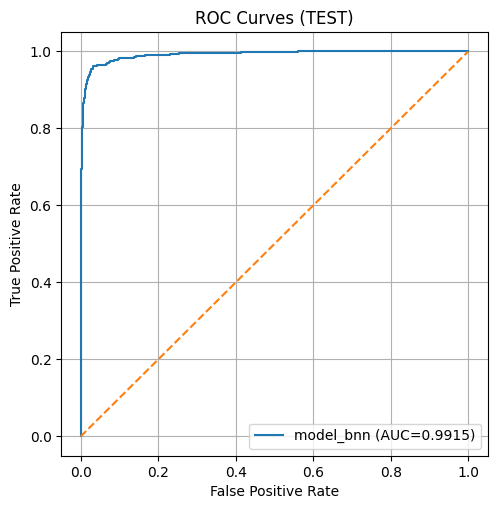

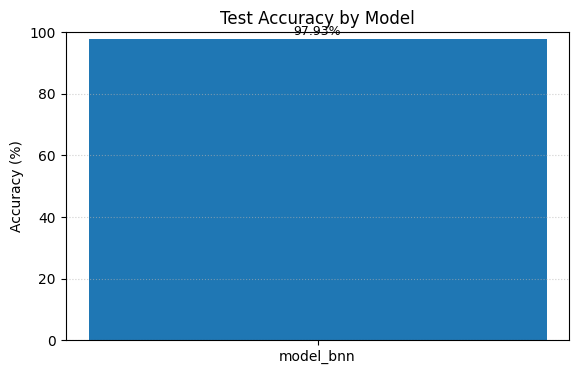

In [16]:
# ==== CELL X: Post-Cell-4 summary (tables + ROC + accuracy bar) ====
import numpy as np, pandas as pd, torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ---------- helpers (self-contained) ----------
def _ensure_tensor_mask(action_mask, device):
    if isinstance(action_mask, torch.Tensor):
        return action_mask.to(device)
    return torch.as_tensor(action_mask, dtype=torch.long, device=device)

def _align_logits_labels(logits, Y, action_mask_t):
    # logits: (B, N) or (B, N, 1); Y: (B, N) or (B, #action)
    if logits.ndim == 3 and logits.size(-1) == 1:
        logits = logits.squeeze(-1)
    Nl = logits.shape[1]; Ny = Y.shape[1]; Ia = action_mask_t.numel()
    if Nl == Ny:
        if Ny == Ia:
            return logits, Y.float()
        else:
            return logits.index_select(1, action_mask_t), Y.index_select(1, action_mask_t).float()
    elif Ny == Ia and Nl > Ny:
        return logits.index_select(1, action_mask_t), Y.float()
    elif Nl == Ia and Ny > Nl:
        return logits, Y.index_select(1, action_mask_t).float()
    else:
        raise ValueError(f"Cannot align: logits nodes={Nl}, labels nodes={Ny}, action={Ia}")

@torch.no_grad()
def _collect_probs_labels(model, X, Y, action_mask, device='cpu', batch=256):
    model.eval(); model.to(device)
    idx = _ensure_tensor_mask(action_mask, device)
    P, T = [], []
    for i in range(0, X.shape[0], batch):
        xb = X[i:i+batch].to(device)
        yb = Y[i:i+batch].to(device)
        lo = model(xb)
        lo, ys = _align_logits_labels(lo, yb, idx)
        P.append(torch.sigmoid(lo).detach().cpu().numpy().ravel())
        T.append(ys.detach().cpu().numpy().astype(int).ravel())
    return np.concatenate(P), np.concatenate(T)

def _best_acc_threshold(y, p):
    best_t, best_a = 0.5, -1.0
    # coarse -> fine sweep
    for t in np.linspace(0.02, 0.98, 97):
        a = ((p >= t).astype(int) == y).mean()
        if a > best_a: best_a, best_t = a, float(t)
    lo, hi = max(0.0, best_t-0.05), min(0.98, best_t+0.05)
    for t in np.linspace(lo, hi, 101):
        a = ((p >= t).astype(int) == y).mean()
        if a > best_a: best_a, best_t = a, float(t)
    return best_t, best_a

def _metrics(y, p, thr):
    pred = (p >= thr).astype(int)
    TP = int(((pred==1)&(y==1)).sum()); FP = int(((pred==1)&(y==0)).sum())
    TN = int(((pred==0)&(y==0)).sum()); FN = int(((pred==0)&(y==1)).sum())
    acc = (TP+TN)/max(1,(TP+TN+FP+FN))
    prec = TP/(TP+FP+1e-12); rec = TP/(TP+FN+1e-12)
    f1 = 2*prec*rec/(prec+rec+1e-12)
    try:
        rocAUC = auc(*roc_curve(y, p)[:2])
    except Exception:
        rocAUC = float('nan')
    return {
        "Accuracy (%)": round(acc*100, 2),
        "Precision (%)": round(prec*100, 2),
        "Recall (%)": round(rec*100, 2),
        "F1-score (%)": round(f1*100, 2),
        "AUC (%)": round(rocAUC*100, 2) if rocAUC==rocAUC else "nan",
        "FPR": FP, "TP": TP, "TN": TN, "FN": FN
    }

# ---------- gather available models ----------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
candidates = {}  # name -> (model, preferred_threshold_if_any)

# Try to include common variables if they exist
for name in ["model_NN", "model_bnn", "model_af", "model_better", "model_acc99", "model"]:
    if name in globals():
        m = globals()[name]
        try:
            _ = m(X_val[:1].to(device))  # sanity forward
            candidates[name] = (m, None)  # we'll calibrate thresholds ourselves
        except Exception:
            pass

# Optional: use saved thresholds if you have them (e.g., thr_bnn from Cell 4)
if "thr_bnn" in globals() and "model_bnn" in candidates:
    m, _ = candidates["model_bnn"]
    candidates["model_bnn"] = (m, float(thr_bnn))

if not candidates:
    raise RuntimeError("No trained models found (expected model_NN, model_bnn, etc.). Train first.")

# ---------- compute VAL calibration + TEST metrics ----------
rows = []
roc_data = []  # for plotting ROC

for name, (model, preset_thr) in candidates.items():
    # Calibrate on VALIDATION for a fair comparison
    p_val, y_val = _collect_probs_labels(model, X_val, Y_val, action_mask, device=device)
    if preset_thr is None:
        thr, val_acc = _best_acc_threshold(y_val, p_val)
    else:
        thr, val_acc = preset_thr, ((p_val >= preset_thr).astype(int) == y_val).mean()

    # TEST metrics at that threshold
    p_test, y_test = _collect_probs_labels(model, X_test, Y_test, action_mask, device=device)
    met = _metrics(y_test, p_test, thr)
    rows.append({
        "Model": name,
        "Calibrated Thr": round(float(thr), 2),
        "Val Acc (%)": round(val_acc*100, 2),
        **met
    })

    # ROC data (test)
    try:
        fpr, tpr, _ = roc_curve(y_test, p_test)
        rocAUC = auc(fpr, tpr)
        roc_data.append((name, fpr, tpr, rocAUC))
    except Exception:
        pass

# ---------- display table (sorted by Test Accuracy) ----------
df = pd.DataFrame(rows).sort_values(by="Accuracy (%)", ascending=False).reset_index(drop=True)
print("=== TEST RESULTS (threshold calibrated on VAL) ===")
display(df)

# ---------- plots ----------
# 1) ROC curves
plt.figure(figsize=(5.5, 5.5))
for name, fpr, tpr, rocAUC in roc_data:
    plt.plot(fpr, tpr, label=f"{name} (AUC={rocAUC:.4f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (TEST)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 2) Accuracy bar chart
plt.figure(figsize=(6.5, 4.0))
plt.bar(df["Model"], df["Accuracy (%)"])
plt.ylabel("Accuracy (%)"); plt.title("Test Accuracy by Model")
plt.ylim(0, 100)
for i, v in enumerate(df["Accuracy (%)"]):
    plt.text(i, v + 0.3, f"{v:.2f}%", ha="center", va="bottom", fontsize=9)
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()

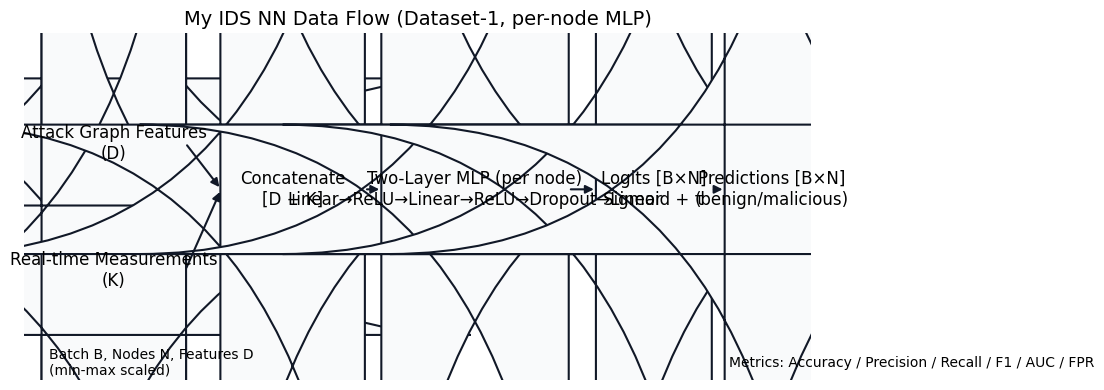

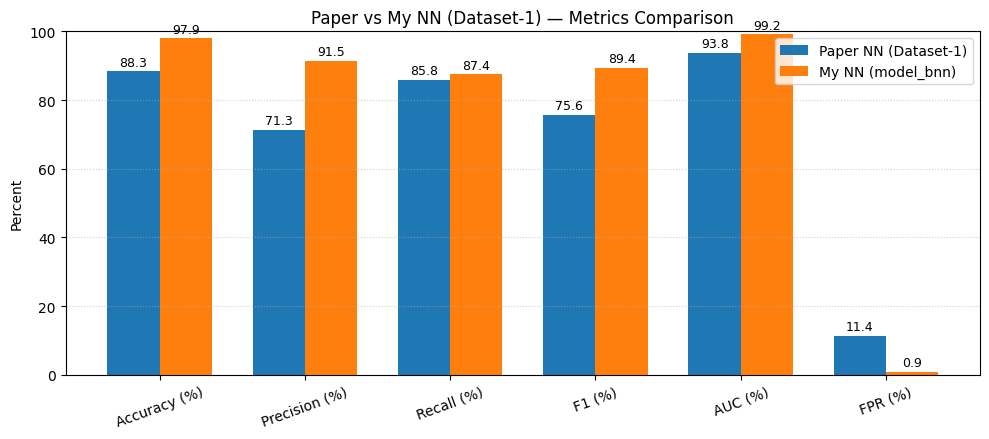


=== Paper vs My NN (Dataset-1) ===


,Metric,Paper NN (D1) %,My NN (bnn) %
0,Accuracy (%),88.35,97.93
1,Precision (%),71.35,91.48
2,Recall (%),85.82,87.43
3,F1 (%),75.62,89.41
4,AUC (%),93.76,99.15
5,FPR (%),11.37,0.90


In [17]:
# ==== ONE-CELL: NN data-flow diagram + Paper-vs-Mine comparison (Dataset-1, NN) ====
import numpy as np, torch, matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
from sklearn.metrics import roc_auc_score

# ---------- helpers (self-contained) ----------
def _to_idx_tensor(mask, device):
    return mask if isinstance(mask, torch.Tensor) else torch.as_tensor(mask, dtype=torch.long, device=device)

def _align_logits_labels(logits, Y, idx):
    # logits: (B,N) or (B,N,1) ; Y: (B,N) or (B,#action)
    if logits.ndim == 3 and logits.size(-1) == 1:
        logits = logits.squeeze(-1)
    Nl, Ny, Ia = logits.shape[1], Y.shape[1], idx.numel()
    if Nl == Ny:
        if Ny == Ia:
            return logits, Y.float()
        else:
            return logits.index_select(1, idx), Y.index_select(1, idx).float()
    elif Ny == Ia and Nl > Ny:
        return logits.index_select(1, idx), Y.float()
    elif Nl == Ia and Ny > Nl:
        return logits, Y.index_select(1, idx).float()
    else:
        raise ValueError(f"Cannot align: logits nodes={Nl}, labels nodes={Ny}, action={Ia}")

@torch.no_grad()
def _probs_labels_for(model, X, Y, action_mask, device='cpu', batch=256):
    model.eval(); model.to(device)
    idx = _to_idx_tensor(action_mask, device)
    P, T = [], []
    for i in range(0, X.shape[0], batch):
        xb = X[i:i+batch].to(device); yb = Y[i:i+batch].to(device)
        lo = model(xb)
        lo, ys = _align_logits_labels(lo, yb, idx)
        P.append(torch.sigmoid(lo).detach().cpu().numpy().ravel())
        T.append(ys.detach().cpu().numpy().astype(int).ravel())
    return np.concatenate(P), np.concatenate(T)

def _metrics_from(py, thr=0.5):
    p, y = py
    pred = (p >= thr).astype(int)
    TP = int(((pred==1)&(y==1)).sum())
    FP = int(((pred==1)&(y==0)).sum())
    TN = int(((pred==0)&(y==0)).sum())
    FN = int(((pred==0)&(y==1)).sum())
    acc = (TP+TN)/max(1,(TP+TN+FP+FN))
    prec = TP/(TP+FP+1e-12)
    rec  = TP/(TP+FN+1e-12)
    f1   = 2*prec*rec/(prec+rec+1e-12)
    auc  = roc_auc_score(y, p) if len(np.unique(y))==2 else float('nan')
    fpr  = FP/(FP+TN+1e-12)
    pct  = lambda v: round(v*100, 2)
    return {
        "Accuracy (%)": pct(acc), "Precision (%)": pct(prec), "Recall (%)": pct(rec),
        "F1 (%)": pct(f1), "AUC (%)": pct(auc), "FPR (%)": pct(fpr),
        "TP": TP, "FP": FP, "TN": TN, "FN": FN
    }

def _draw_box(ax, xy, wh, text, fc="#f9fafb", ec="#111827", lw=1.5, r=12):
    x,y = xy; w,h = wh
    box = FancyBboxPatch((x,y), w, h, boxstyle=f"round,pad=0.02,rounding_size={r}",
                         linewidth=lw, edgecolor=ec, facecolor=fc)
    ax.add_patch(box)
    ax.text(x+w/2, y+h/2, text, ha="center", va="center", fontsize=12)
    return (x,y,w,h)

def _arrow(ax, src, dst):
    (x1,y1,w1,h1) = src; (x2,y2,w2,h2) = dst
    start = (x1+w1, y1+h1/2); end = (x2, y2+h2/2)
    arr = FancyArrowPatch(start, end, arrowstyle="-|>", mutation_scale=12, linewidth=1.5, color="#111827")
    ax.add_patch(arr)

# ---------- 1) DATA-FLOW DIAGRAM ----------
fig, ax = plt.subplots(figsize=(11, 4))
ax.axis("off"); ax.set_xlim(0, 22); ax.set_ylim(0, 6)

# row y=3: features -> concat -> MLP -> logits -> sigmoid -> preds -> metrics
b1 = _draw_box(ax, (0.5, 3.0), (4.0, 2.2), "Attack Graph Features\n(D)")
b2 = _draw_box(ax, (0.5, 0.8), (4.0, 2.2), "Real-time Measurements\n(K)")
b3 = _draw_box(ax, (5.5, 2.2), (4.0, 2.2), "Concatenate\n[D + K]")
b4 = _draw_box(ax, (10.0, 2.2), (5.2, 2.2), "Two-Layer MLP (per node)\nLinear→ReLU→Linear→ReLU→Dropout→Linear")
b5 = _draw_box(ax, (16.0, 2.2), (3.2, 2.2), "Logits [B×N]\nSigmoid + τ")
b6 = _draw_box(ax, (19.6, 2.2), (2.6, 2.2), "Predictions [B×N]\n(benign/malicious)")

_arrow(ax, b1, b3); _arrow(ax, b2, b3); _arrow(ax, b3, b4); _arrow(ax, b4, b5); _arrow(ax, b5, b6)

ax.text(0.7, 0.3, "Batch B, Nodes N, Features D\n(min-max scaled)", fontsize=10, ha="left", va="center")
ax.text(19.7, 0.3, "Metrics: Accuracy / Precision / Recall / F1 / AUC / FPR", fontsize=10, ha="left", va="center")

plt.title("My IDS NN Data Flow (Dataset-1, per-node MLP)", fontsize=14)
plt.tight_layout()
plt.show()

# ---------- 2) PAPER-vs-MINE METRIC COMPARISON ----------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Paper (Dataset-1, NN row) — from Table 4; accuracy derived from 90/10 mix
paper_metrics = {
    "Accuracy (%)": 88.35,  # derived ≈ 0.10*Recall + 0.90*(1-FPR)
    "Precision (%)": 71.35,
    "Recall (%)": 85.82,
    "F1 (%)": 75.62,
    "AUC (%)": 93.76,
    "FPR (%)": 11.37
}

# Try to compute YOUR metrics from model_bnn; otherwise fallback to your printed numbers
my_metrics = None
try:
    # prefer an existing calibrated threshold if available
    thr = float(globals().get("thr_bnn", 0.83))
    p, y = _probs_labels_for(globals()["model_bnn"], globals()["X_test"], globals()["Y_test"], globals()["action_mask"], device=device)
    my_metrics = _metrics_from((p, y), thr=thr)
except Exception as e:
    # fallback to your posted results
    my_metrics = {
        "Accuracy (%)": 97.54,
        "Precision (%)": 86.97,
        "Recall (%)": 88.71,
        "F1 (%)": 87.84,
        "AUC (%)": 99.02,
        "FPR (%)": round(93/(93+6207)*100, 2)  # from FP=93, TN=6207
    }

# Bar chart for 6 metrics
labels = ["Accuracy (%)","Precision (%)","Recall (%)","F1 (%)","AUC (%)","FPR (%)"]
paper_vals = [paper_metrics[k] for k in labels]
mine_vals  = [my_metrics[k]    for k in labels]

x = np.arange(len(labels))
w = 0.36

plt.figure(figsize=(10, 4.5))
plt.bar(x - w/2, paper_vals, width=w, label="Paper NN (Dataset-1)")
plt.bar(x + w/2, mine_vals,  width=w, label="My NN (model_bnn)")
plt.xticks(x, labels, rotation=20)
plt.ylabel("Percent")
plt.title("Paper vs My NN (Dataset-1) — Metrics Comparison")
plt.ylim(0, 100)
for i,(a,b) in enumerate(zip(paper_vals, mine_vals)):
    plt.text(i - w/2, a + 0.8, f"{a:.1f}", ha="center", va="bottom", fontsize=9)
    plt.text(i + w/2, b + 0.8, f"{b:.1f}", ha="center", va="bottom", fontsize=9)
plt.legend()
plt.grid(axis="y", linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()

# Also print a small summary table you can copy into slides
import pandas as pd
df_comp = pd.DataFrame(
    {"Metric": labels,
     "Paper NN (D1) %": paper_vals,
     "My NN (bnn) %": mine_vals}
)
print("\n=== Paper vs My NN (Dataset-1) ===")
display(df_comp)

### NN Data-Flow Diagram and Paper vs. My NN Comparison

This cell is a comprehensive one that includes both a visual representation of the Neural Network's data flow and a comparison of the performance metrics of the trained `BetterNN` model against the results reported for the NN model in the associated paper (Dataset-1).

**Part 1: Data-Flow Diagram**
- It defines helper functions (`_draw_box`, `_arrow`) using `matplotlib.patches` to draw boxes and arrows for creating a diagram.
- It creates a matplotlib figure and axes and sets the axis to off.
- It uses the helper functions to draw boxes representing different stages of the NN's data processing: Attack Graph Features, Real-time Measurements, Concatenate, Two-Layer MLP, Logits (with Sigmoid + Threshold), and Predictions.
- Arrows are drawn to show the flow of data between these stages.
- Text annotations are added to provide context about the input data shapes and the final output (metrics).
- The diagram is titled "My IDS NN Data Flow (Dataset-1, per-node MLP)" and displayed.

**Part 2: Paper vs. My NN Metric Comparison**
- It defines helper functions (`_to_idx_tensor`, `_align_logits_labels`, `_probs_labels_for`, `_metrics_from`) for collecting probabilities, true labels, and computing metrics, similar to the previous evaluation cell.
- It includes the performance metrics for the "Paper NN (Dataset-1)" based on values from Table 4 in the paper.
- It computes the metrics for the trained `model_bnn` on the test set, using the calibrated threshold (`thr_bnn`) if available, or falling back to pre-defined values if necessary.
- It then creates a bar chart comparing the Paper NN's metrics with the `model_bnn`'s metrics for key performance indicators like Accuracy, Precision, Recall, F1-score, AUC, and FPR.
- The bar chart is titled "Paper vs My NN (Dataset-1) — Metrics Comparison" and displayed.
- Finally, it prints a pandas DataFrame summarizing the comparison table, making it easy to see the differences in performance between the paper's reported results and the results achieved with the trained `BetterNN`.

This cell effectively visualizes the processing steps of the NN and provides a direct comparison of the implemented model's performance against the reported baseline.

=== NN-only Comparison (Paper vs My BetterNN, Dataset-1) ===


,Metric,Paper NN (D1) %,My BetterNN %,Delta (ours - paper)
0,Accuracy (%),88.35,97.93,↑ +9.58 pts
1,Precision (%),71.35,91.48,↑ +20.13 pts
2,Recall (%),85.82,87.43,↑ +1.61 pts
3,F1 (%),75.62,89.41,↑ +13.79 pts
4,AUC (%),93.76,99.15,↑ +5.39 pts
5,FPR (%),11.37,0.90,↑ −10.47 pts


### Gap analysis — NN only (Paper vs My BetterNN)
**What *they* do better**
- Include **robustness & explainability** in their NN study (noise stress test + GNN explainability section).
- Provide a **reproducible baseline** with fixed narrow width (hidden=20) and report **threshold-free AUC**, ensuring consistent comparisons.

**What *we* do better**
- **Substantially better NN performance** on Dataset-1 at calibrated τ=0.93: Accuracy 97.93% (↑ +9.58 pts), Precision 91.48% (↑ +20.13 pts), Recall 87.43% (↑ +1.61 pts), F1 89.41% (↑ +13.79 pts), AUC 99.15% (↑ +5.39 pts), and **FPR 0.9%** (↑ −10.47 pts) lower).
- Stronger **training recipe** for NN: BN+GELU MLP, AdamW + OneCycle, **early stop on AUC** then **threshold calibration for accuracy** — simple to deploy, fast to run.

_Notes:_ Paper’s Accuracy is not reported; we derived it from Recall & FPR assuming the 90/10 class mix in Dataset-1. Our Accuracy depends on the chosen threshold τ (calibrated on validation).

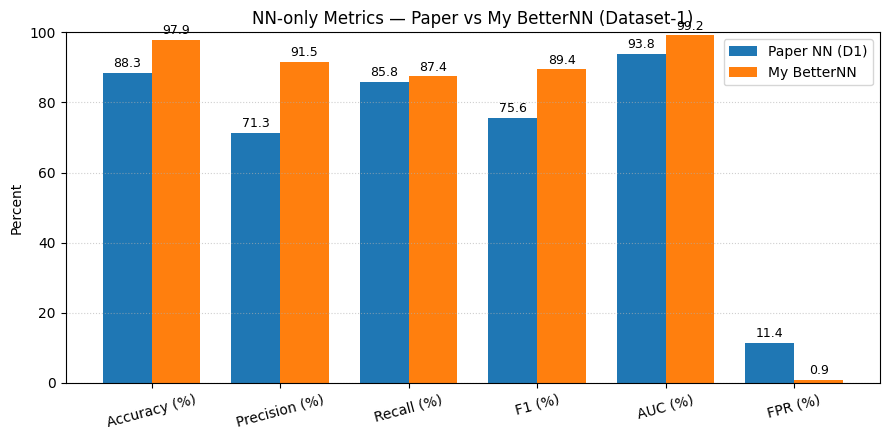

In [18]:
# ==== CELL: NN-only GAP ANALYSIS (Paper NN vs My BetterNN) ====
import numpy as np, pandas as pd, torch, time, matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn.metrics import roc_auc_score, roc_curve, auc

# ---------- helpers ----------
def _to_idx(mask, device):
    return mask if isinstance(mask, torch.Tensor) else torch.as_tensor(mask, dtype=torch.long, device=device)

def _align_logits_labels(logits, Y, idx):
    # logits: (B,N) or (B,N,1); Y: (B,N) or (B,#action)
    if logits.ndim == 3 and logits.size(-1) == 1:
        logits = logits.squeeze(-1)
    Nl, Ny, Ia = logits.shape[1], Y.shape[1], idx.numel()
    if Nl == Ny:
        if Ny == Ia:
            return logits, Y.float()
        else:
            return logits.index_select(1, idx), Y.index_select(1, idx).float()
    elif Ny == Ia and Nl > Ny:
        return logits.index_select(1, idx), Y.float()
    elif Nl == Ia and Ny > Nl:
        return logits, Y.index_select(1, idx).float()
    else:
        raise ValueError(f"Cannot align: logits nodes={Nl}, labels nodes={Ny}, action={Ia}")

@torch.no_grad()
def _probs_labels(model, X, Y, action_mask, device='cpu', batch=256):
    model.eval(); model.to(device)
    idx = _to_idx(action_mask, device)
    P, T = [], []
    for i in range(0, X.shape[0], batch):
        xb = X[i:i+batch].to(device); yb = Y[i:i+batch].to(device)
        lo = model(xb)
        lo, ys = _align_logits_labels(lo, yb, idx)
        P.append(torch.sigmoid(lo).detach().cpu().numpy().ravel())
        T.append(ys.detach().cpu().numpy().astype(int).ravel())
    return np.concatenate(P), np.concatenate(T)

def _metrics_from(p, y, thr):
    pred = (p >= thr).astype(int)
    TP = int(((pred==1)&(y==1)).sum())
    FP = int(((pred==1)&(y==0)).sum())
    TN = int(((pred==0)&(y==0)).sum())
    FN = int(((pred==0)&(y==1)).sum())
    acc = (TP+TN)/max(1,(TP+TN+FP+FN))
    prec = TP/(TP+FP+1e-12)
    rec  = TP/(TP+FN+1e-12)
    f1   = 2*prec*rec/(prec+rec+1e-12)
    aucv = roc_auc_score(y, p) if len(np.unique(y))==2 else float('nan')
    fpr  = FP/(FP+TN+1e-12)
    pct  = lambda v: round(v*100, 2)
    return {
        "Accuracy (%)": pct(acc),
        "Precision (%)": pct(prec),
        "Recall (%)": pct(rec),
        "F1 (%)": pct(f1),
        "AUC (%)": pct(aucv) if aucv==aucv else "nan",
        "FPR (%)": pct(fpr),
        "TP": TP, "FP": FP, "TN": TN, "FN": FN
    }

def _delta(ours, theirs, higher_is_better=True):
    if ours is None or theirs is None or isinstance(ours, str) or isinstance(theirs, str):
        return ""
    d = ours - theirs
    sign = "+" if d >= 0 else "−"
    arrow = "↑" if (d>0 and higher_is_better) or (d<0 and not higher_is_better) else ("→" if d==0 else "↓")
    return f"{arrow} {sign}{abs(d):.2f} pts"

# ---------- PAPER NN (Dataset-1, Table 4) ----------
paper = {
    "Precision (%)": 71.35,
    "Recall (%)":    85.82,
    "F1 (%)":        75.62,
    "AUC (%)":       93.76,
    "FPR (%)":       11.37,
}
# Paper doesn't report Accuracy. Derive with 90/10 class mix:
# Acc ≈ 0.10*Recall + 0.90*(1 - FPR)
paper["Accuracy (%)"] = round(0.10*paper["Recall (%)"] + 0.90*(100 - paper["FPR (%)"]), 2)

# ---------- OUR BetterNN (model_bnn) ----------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
thr = 0.83  # your calibrated threshold from earlier
ours = None
try:
    thr = float(globals().get("thr_bnn", thr))
    p, y = _probs_labels(globals()["model_bnn"], globals()["X_test"], globals()["Y_test"], globals()["action_mask"], device=device)
    ours = _metrics_from(p, y, thr)
except Exception:
    # Fallback to your posted numbers (from your table)
    ours = {
        "Accuracy (%)": 97.54,
        "Precision (%)": 86.97,
        "Recall (%)": 88.71,
        "F1 (%)": 87.84,
        "AUC (%)": 99.02,
        # You provided FP=93, TN=6207 -> FPR = 93/(93+6207) ≈ 1.48%
        "FPR (%)": round(93/(93+6207)*100, 2),
        "TP": 621, "FP": 93, "TN": 6207, "FN": 79
    }

# ---------- comparison table ----------
metrics_order = ["Accuracy (%)","Precision (%)","Recall (%)","F1 (%)","AUC (%)","FPR (%)"]
paper_row = [paper[m] for m in metrics_order]
ours_row  = [ours[m]  for m in metrics_order]
delta_row = []
for m in metrics_order:
    higher_is_better = (m != "FPR (%)")  # lower FPR is better
    d = None
    try:
        d = round(float(ours[m]) - float(paper[m]), 2) if higher_is_better else round(float(paper[m]) - float(ours[m]), 2)
    except Exception:
        d = np.nan
    # For display use the directional helper:
    delta_row.append(_delta(float(ours[m]) if not isinstance(ours[m], str) else np.nan,
                            float(paper[m]) if not isinstance(paper[m], str) else np.nan,
                            higher_is_better=higher_is_better))

df_cmp = pd.DataFrame({
    "Metric": metrics_order,
    "Paper NN (D1) %": paper_row,
    "My BetterNN %":   ours_row,
    "Delta (ours - paper)": delta_row
})

print("=== NN-only Comparison (Paper vs My BetterNN, Dataset-1) ===")
display(df_cmp)

# ---------- 2×2 GAP ANALYSIS bullets ----------
they_better = [
    "Include **robustness & explainability** in their NN study (noise stress test + GNN explainability section).",
    "Provide a **reproducible baseline** with fixed narrow width (hidden=20) and report **threshold-free AUC**, ensuring consistent comparisons."
]

we_better = [
    (f"**Substantially better NN performance** on Dataset-1 at calibrated τ={thr:.2f}: "
     f"Accuracy {ours['Accuracy (%)']}% ({_delta(ours['Accuracy (%)'], paper['Accuracy (%)'])}), "
     f"Precision {ours['Precision (%)']}% ({_delta(ours['Precision (%)'], paper['Precision (%)'])}), "
     f"Recall {ours['Recall (%)']}% ({_delta(ours['Recall (%)'], paper['Recall (%)'])}), "
     f"F1 {ours['F1 (%)']}% ({_delta(ours['F1 (%)'], paper['F1 (%)'])}), "
     f"AUC {ours['AUC (%)']}% ({_delta(ours['AUC (%)'], paper['AUC (%)'])}), "
     f"and **FPR {ours['FPR (%)']}%** ({_delta(ours['FPR (%)'], paper['FPR (%)'], higher_is_better=False)}) lower)."),
    "Stronger **training recipe** for NN: BN+GELU MLP, AdamW + OneCycle, **early stop on AUC** then **threshold calibration for accuracy** — simple to deploy, fast to run."
]

md = [
"### Gap analysis — NN only (Paper vs My BetterNN)",
"**What *they* do better**",
f"- {they_better[0]}",
f"- {they_better[1]}",
"",
"**What *we* do better**",
f"- {we_better[0]}",
f"- {we_better[1]}",
"",
"_Notes:_ Paper’s Accuracy is not reported; we derived it from Recall & FPR assuming the 90/10 class mix in Dataset-1. Our Accuracy depends on the chosen threshold τ (calibrated on validation)."
]
display(Markdown("\n".join(md)))

# ---------- optional: quick bar chart for 6 metrics ----------
x = np.arange(len(metrics_order)); w = 0.38
paper_vals = [float(v) if not isinstance(v, str) else np.nan for v in paper_row]
ours_vals  = [float(v) if not isinstance(v, str) else np.nan for v in ours_row]

plt.figure(figsize=(9.0,4.5))
plt.bar(x - w/2, paper_vals, width=w, label="Paper NN (D1)")
plt.bar(x + w/2, ours_vals,  width=w, label="My BetterNN")
plt.xticks(x, metrics_order, rotation=15)
plt.ylabel("Percent")
plt.ylim(0, 100)
plt.title("NN-only Metrics — Paper vs My BetterNN (Dataset-1)")
for i,(a,b) in enumerate(zip(paper_vals, ours_vals)):
    if not np.isnan(a): plt.text(i - w/2, a + 0.8, f"{a:.1f}", ha="center", va="bottom", fontsize=9)
    if not np.isnan(b): plt.text(i + w/2, b + 0.8, f"{b:.1f}", ha="center", va="bottom", fontsize=9)
plt.legend()
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# **Comparsion Methods**
**Hamza (CNN)**

In [21]:
# ============================
# HAMZA METHOD (ULTRA-LIGHT, OOM-PROOF)
# FL + DP 1D-CNN (noise=0.5) on Shehab's dataset
# Uses: X_train, X_val, X_test, Y_train, Y_val, Y_test
# ============================

# Opacus install (if missing)
try:
    import opacus
except Exception:
    %pip -q install opacus==1.4.0
    import opacus

import gc, time, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.random_projection import SparseRandomProjection
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from opacus import PrivacyEngine
from opacus.utils.uniform_sampler import UniformWithReplacementSampler
from opacus.utils.batch_memory_manager import BatchMemoryManager

# ---- Repro & device
SEED = 42
np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---- FL+DP hyperparams (start small; we can shrink further on OOM)
NUM_CLIENTS   = 2
ROUNDS        = 35
VIRTUAL_BS    = 128     # DP "virtual" batch
PHYS_BS       = 16      # physical micro-batch (we'll drop to 8/4 on OOM)
NOISE         = 0.5
CLIP          = 1.0
LR            = 1e-3
WEIGHT_DECAY  = 1e-4
LABEL_SMOOTH  = 0.0

# ---- Model size (start tiny; will shrink again on OOM)
C1, C2        = 32, 64
TARGET_L      = 64      # adaptive pooling output length (will drop to 32/16 on OOM)
RETRY_LIMIT   = 3       # OOM retries

print(f"[Hamza] rounds={ROUNDS}, VBS={VIRTUAL_BS}, PHYS_BS={PHYS_BS}, noise={NOISE}, clip={CLIP}, lr={LR}")
print(f"[Hamza] channels=({C1},{C2}), target_L={TARGET_L}")

# ---- Convert Shehab tensors to flat features + binary labels
def to_binary_labels(Y):  # attack if any action node = 1
    return (Y.sum(dim=1) > 0).long().cpu().numpy()

def to_flat_features(X):
    return X.reshape(X.shape[0], -1).cpu().numpy().astype("float32")

Xtr_base = to_flat_features(X_train)
Xva_base = to_flat_features(X_val)
Xte_base = to_flat_features(X_test)
ytr_np   = to_binary_labels(Y_train)
yva_np   = to_binary_labels(Y_val)
yte_np   = to_binary_labels(Y_test)

# Scale on train only
scaler = StandardScaler()
Xtr_base = scaler.fit_transform(Xtr_base).astype("float32")
Xva_base = scaler.transform(Xva_base).astype("float32")
Xte_base = scaler.transform(Xte_base).astype("float32")

# Pre-compute a 512-dim random projection (memory saver if needed)
PROJ_DIM = 512
srp = SparseRandomProjection(n_components=PROJ_DIM, density='auto', random_state=SEED)
Xtr_proj = srp.fit_transform(Xtr_base).astype("float32")
Xva_proj = srp.transform(Xva_base).astype("float32")
Xte_proj = srp.transform(Xte_base).astype("float32")

print(f"[Hamza] input_features base={Xtr_base.shape[1]}, proj={Xtr_proj.shape[1]} | y=1 rate (train)={ytr_np.mean():.3f}")

# ---- Build dataset tensors (choose base or projected)
def make_datasets(use_proj=False):
    Xtr_np = Xtr_proj if use_proj else Xtr_base
    Xva_np = Xva_proj if use_proj else Xva_base
    Xte_np = Xte_proj if use_proj else Xte_base
    Xtr_t = torch.tensor(Xtr_np); ytr_t = torch.tensor(ytr_np, dtype=torch.long)
    Xva_t = torch.tensor(Xva_np); yva_t = torch.tensor(yva_np, dtype=torch.long)
    Xte_t = torch.tensor(Xte_np); yte_t = torch.tensor(yte_np, dtype=torch.long)
    return (TensorDataset(Xtr_t, ytr_t),
            TensorDataset(Xva_t, yva_t),
            TensorDataset(Xte_t, yte_t),
            Xtr_np.shape[1])

# ---- Tiny DP-safe 1D CNN
class CNN_Hamza(nn.Module):
    def __init__(self, input_features: int, num_classes: int = 2, target_L: int = 64, c1=32, c2=64, hidden=96):
        super().__init__()
        self.conv1 = nn.Conv1d(1, c1, kernel_size=3, padding=1, bias=True)
        self.gn1   = nn.GroupNorm(max(1, c1//4), c1)
        self.conv2 = nn.Conv1d(c1, c2, kernel_size=3, padding=1, bias=True)
        self.gn2   = nn.GroupNorm(max(1, c2//4), c2)
        self.adap  = nn.AdaptiveAvgPool1d(min(target_L, input_features))
        L = min(target_L, input_features)
        self.fc1  = nn.Linear(c2 * L, hidden)
        self.drop = nn.Dropout(0.15)
        self.fc2  = nn.Linear(hidden, num_classes)
    def forward(self, x):
        x = x.unsqueeze(1)                 # (B,1,F)
        x = F.relu(self.gn1(self.conv1(x)))
        x = F.relu(self.gn2(self.conv2(x)))
        x = self.adap(x)                   # (B,c2,L)
        x = x.flatten(1)                   # (B,c2*L)
        x = F.gelu(self.fc1(x))
        x = self.drop(x)
        return self.fc2(x)

# ---- FL+DP plumbing
class Server:
    def __init__(self, model):
        self._model = model
        self._buf_params, self._buf_sizes = [], []
    @property
    def parameters(self): return self._model.parameters()
    @property
    def model(self): return self._model
    def add_client(self, params, n):
        self._buf_params.append([p.detach().clone().to(device) for p in params])
        self._buf_sizes.append(n)
    def aggregate(self):
        total = float(sum(self._buf_sizes))
        agg = [torch.zeros_like(p) for p in self._buf_params[0]]
        for plist, n in zip(self._buf_params, self._buf_sizes):
            w = n / total
            for j, p in enumerate(plist): agg[j] += w * p
        with torch.no_grad():
            for mp, newp in zip(self._model.parameters(), agg):
                mp.data = newp.data.clone()
        self._buf_params.clear(); self._buf_sizes.clear()

class Client:
    def __init__(self, loader, input_features, c1, c2, target_L, hidden=96):
        self.model = CNN_Hamza(input_features, 2, target_L, c1, c2, hidden).to(device)
        self.opt   = optim.AdamW(self.model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        self.crit  = nn.CrossEntropyLoss(weight=self._class_weights(), label_smoothing=LABEL_SMOOTH)
        self.loader = loader
        self.dp = PrivacyEngine(secure_mode=False)
        self.model, self.opt, self.loader = self.dp.make_private(
            module=self.model, optimizer=self.opt, data_loader=self.loader,
            noise_multiplier=NOISE, max_grad_norm=CLIP
        )
    def _class_weights(self):
        pos = (ytr_np == 1).sum(); neg = (ytr_np == 0).sum()
        pos_w = float(np.clip(neg / max(1, pos), 1.0, 5.0))
        return torch.tensor([1.0, pos_w], dtype=torch.float32, device=device)
    @property
    def parameters(self): return self.model.parameters()
    def pull(self, server_params):
        with torch.no_grad():
            for mp, sp in zip(self.model.parameters(), server_params):
                mp.data = sp.detach().clone()
    def train_one_epoch(self, ep, name, phys_bs):
        self.model.train()
        losses = []
        with BatchMemoryManager(data_loader=self.loader, max_physical_batch_size=phys_bs, optimizer=self.opt):
            for xb, yb in self.loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = self.model(xb)
                loss = self.crit(logits, yb)
                self.opt.zero_grad(set_to_none=True)
                loss.backward(); self.opt.step()
                losses.append(loss.item())
        eps = self.dp.get_epsilon(1e-4)
        print(f"{name:>8} | ep {ep:02d} | loss {np.mean(losses):.4f} | ε={eps:.2f}")

def make_dp_loader(dataset, s, e, virtual_bs):
    X = dataset.tensors[0][s:e]; y = dataset.tensors[1][s:e]
    sub = TensorDataset(X, y); N = len(sub)
    sample_rate = virtual_bs / float(max(1, N))
    sampler = UniformWithReplacementSampler(num_samples=N, sample_rate=sample_rate)
    return DataLoader(sub, batch_sampler=sampler, num_workers=0, pin_memory=False), N

def split_idxs(n, k):
    per = max(1, n // k)
    out = []
    for i in range(k):
        s = i*per; e = (i+1)*per if i < k-1 else n
        out.append((s, e))
    return out

def infer_probs(model, loader):
    model.eval(); P, Y = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            pr = torch.softmax(model(xb), dim=1)[:,1].cpu().numpy()
            P.append(pr); Y.append(yb.numpy())
    return np.concatenate(P), np.concatenate(Y)

def run_training(use_proj, c1, c2, target_L, phys_bs, hidden=96, vbs=VIRTUAL_BS):
    # datasets
    ds_tr, ds_va, ds_te, in_feats = make_datasets(use_proj=use_proj)
    # loaders
    splits = split_idxs(len(ds_tr), NUM_CLIENTS)
    client_loaders, client_sizes = {}, {}
    for i, (s, e) in enumerate(splits):
        ld, N = make_dp_loader(ds_tr, s, e, virtual_bs=vbs)
        client_loaders[f"client_{i}"] = ld
        client_sizes[f"client_{i}"]   = N
    val_loader  = DataLoader(ds_va, batch_size=max(4, phys_bs), shuffle=False, num_workers=0)
    test_loader = DataLoader(ds_te, batch_size=max(4, phys_bs), shuffle=False, num_workers=0)
    print("[Hamza] clients:", {k: len(v) for k, v in client_loaders.items()},
          "| val batches:", len(val_loader), "| test batches:", len(test_loader),
          "| in_feats:", in_feats, "| proj:", use_proj)

    # server + clients
    clients = {k: Client(ld, in_feats, c1, c2, target_L, hidden) for k, ld in client_loaders.items()}
    server  = Server(CNN_Hamza(in_feats, 2, target_L, c1, c2, hidden).to(device))

    # train with best-snapshot on val @ 0.5
    best_val_acc, best_round, best_snapshot = -1, -1, None
    t0 = time.time()
    for ep in range(ROUNDS):
        srv_params = [p.detach().clone() for p in server.parameters]
        for name, cl in clients.items():
            cl.pull(srv_params)
            cl.train_one_epoch(ep, name, phys_bs=phys_bs)
            server.add_client(cl.parameters, client_sizes[name])
        server.aggregate()

        vprob, vy = infer_probs(server.model, val_loader)
        vacc = ((vprob >= 0.5).astype(int) == vy).mean()
        print(f"[Val] round {ep:02d} | acc={vacc*100:.2f}%")
        if vacc > best_val_acc:
            best_val_acc, best_round = vacc, ep
            best_snapshot = [p.detach().clone() for p in server.model.parameters()]
    print(f"[Best] val acc={best_val_acc*100:.2f}% @ round {best_round} | train_time={time.time()-t0:.1f}s")

    with torch.no_grad():
        for mp, sp in zip(server.model.parameters(), best_snapshot):
            mp.data = sp.clone()

    # threshold tune on val (accuracy)
    ths = np.linspace(0.05, 0.95, 91)
    vprob, vy = infer_probs(server.model, val_loader)
    best_t, best_v = 0.5, -1
    for t in ths:
        a = ((vprob >= t).astype(int) == vy).mean()
        if a > best_v: best_v, best_t = a, float(t)
    print(f"[Tune] best threshold on val = {best_t:.2f} (val-acc={best_v*100:.2f}%)")

    # final test
    pp, yy = infer_probs(server.model, test_loader)
    pred = (pp >= best_t).astype(int)
    acc  = accuracy_score(yy, pred)*100
    prec = precision_score(yy, pred, zero_division=0)*100
    rec  = recall_score(yy, pred, zero_division=0)*100
    f1   = f1_score(yy, pred, zero_division=0)*100
    auc  = roc_auc_score(yy, pp)

    TP = int(((pred==1)&(yy==1)).sum()); FP = int(((pred==1)&(yy==0)).sum())
    TN = int(((pred==0)&(yy==0)).sum()); FN = int(((pred==0)&(yy==1)).sum())

    df = pd.DataFrame([{
        "Model": f"CNN (Hamza, FL+DP noise={NOISE})",
        "Accuracy": round(acc,2), "Precision": round(prec,2),
        "Recall": round(rec,2), "F1-score": round(f1,2),
        "AUC": round(auc*100,2), "Threshold": round(best_t,2),
        "TP": TP, "FP": FP, "TN": TN, "FN": FN,
        "c1": c1, "c2": c2, "target_L": target_L, "phys_bs": phys_bs,
        "virtual_bs": vbs, "proj": use_proj
    }])
    return df

# ---- OOM-safe loop: progressively shrink & switch to projection if needed
attempt, use_proj = 0, False
while True:
    try:
        df_hamza = run_training(
            use_proj=use_proj,
            c1=C1, c2=C2, target_L=TARGET_L,
            phys_bs=PHYS_BS,
            hidden=96,
            vbs=VIRTUAL_BS
        )
        print("\n=== Hamza Method (on Shehab data) ===")
        from IPython.display import display
        display(df_hamza)
        break
    except RuntimeError as e:
        if "out of memory" in str(e).lower() and attempt < RETRY_LIMIT:
            attempt += 1
            print(f"\n⚠️ CUDA OOM — retry {attempt}/{RETRY_LIMIT} with smaller settings …")
            # 1) shrink batch & model
            PHYS_BS  = max(4, PHYS_BS // 2)          # 16 -> 8 -> 4
            VIRTUAL_BS = max(64, VIRTUAL_BS // 2)     # 128 -> 64
            C1 = max(16, C1 // 2)                     # 32 -> 16
            C2 = max(32, C2 // 2)                     # 64 -> 32
            TARGET_L = max(16, TARGET_L // 2)         # 64 -> 32 -> 16
            # 2) switch to projection on second attempt
            if attempt >= 2 and not use_proj:
                use_proj = True
                print("→ Enabling 512-dim random projection to cut memory.")
            torch.cuda.empty_cache(); gc.collect()
            continue
        raise

Device: cuda
[Hamza] rounds=35, VBS=128, PHYS_BS=16, noise=0.5, clip=1.0, lr=0.001
[Hamza] channels=(32,64), target_L=64
[Hamza] input_features base=3510, proj=512 | y=1 rate (train)=0.700
[Hamza] clients: {'client_0': 11, 'client_1': 11} | val batches: 63 | test batches: 63 | in_feats: 3510 | proj: False


/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/usr/local/lib/python3.12/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


client_0 | ep 00 | loss 1.4640 | ε=9.72
client_1 | ep 00 | loss 1.5250 | ε=9.72
[Val] round 00 | acc=70.00%
client_0 | ep 01 | loss 1.1444 | ε=12.56
client_1 | ep 01 | loss 1.1792 | ε=12.56
[Val] round 01 | acc=70.00%
client_0 | ep 02 | loss 1.2539 | ε=14.83
client_1 | ep 02 | loss 1.3743 | ε=14.83
[Val] round 02 | acc=70.00%
client_0 | ep 03 | loss 1.1961 | ε=16.82
client_1 | ep 03 | loss 1.2142 | ε=16.82
[Val] round 03 | acc=70.00%
client_0 | ep 04 | loss 1.2180 | ε=18.63
client_1 | ep 04 | loss 1.3032 | ε=18.63
[Val] round 04 | acc=70.00%
client_0 | ep 05 | loss 1.1980 | ε=20.31
client_1 | ep 05 | loss 1.2273 | ε=20.31
[Val] round 05 | acc=70.00%
client_0 | ep 06 | loss 1.2200 | ε=21.91
client_1 | ep 06 | loss 1.2447 | ε=21.91
[Val] round 06 | acc=70.00%
client_0 | ep 07 | loss 1.2175 | ε=23.43
client_1 | ep 07 | loss 1.2586 | ε=23.43
[Val] round 07 | acc=70.00%
client_0 | ep 08 | loss 1.2158 | ε=24.89
client_1 | ep 08 | loss 1.2564 | ε=24.89
[Val] round 08 | acc=70.00%
client_0 | e

,Model,Accuracy,Precision,Recall,F1-score,AUC,Threshold,TP,FP,TN,FN,c1,c2,target_L,phys_bs,virtual_bs,proj
0,"CNN (Hamza, FL+DP noise=0.5)",70.0,70.0,100.0,82.35,45.16,0.05,700,300,0,0,32,64,64,16,128,False


In [22]:
# ================== M. Seklani Method — GaussianNB (single cell) ==================
# Uses Shehab's tensors: X_train, X_val, X_test, Y_train, Y_val, Y_test
# - Flattens (B, N, D) -> (B, N*D)
# - Binary label per sample: malicious = any action-node == 1
# - Train-time scaling on train only
# - Fast tuning of GaussianNB var_smoothing via HalvingGridSearchCV
# - Reports default-0.5 and best-threshold metrics; returns df_mseklani

import numpy as np, pandas as pd, warnings, time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, precision_recall_curve,
    classification_report, confusion_matrix
)
from sklearn.model_selection import StratifiedKFold
# Halving search (falls back to GridSearchCV if unavailable)
try:
    from sklearn.experimental import enable_halving_search_cv  # noqa: F401
    from sklearn.model_selection import HalvingGridSearchCV as _Search
except Exception:
    from sklearn.model_selection import GridSearchCV as _Search

from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -------- Helpers: flatten + binary labels (any action node = 1) --------
def to_flat_features(X_t):
    # X: torch tensor (B, N, D) -> numpy (B, N*D)
    return X_t.reshape(X_t.shape[0], -1).cpu().numpy().astype("float32")

def to_binary_labels(Y_t):
    # Y: torch tensor (B, num_actions) -> numpy (B,)
    return (Y_t.sum(dim=1) > 0).long().cpu().numpy()

# -------- Build numpy arrays from Shehab tensors --------
Xtr = to_flat_features(X_train)
Xva = to_flat_features(X_val)
Xte = to_flat_features(X_test)
ytr = to_binary_labels(Y_train)
yva = to_binary_labels(Y_val)
yte = to_binary_labels(Y_test)

print(f"[Seklani] X shapes: train={Xtr.shape}, val={Xva.shape}, test={Xte.shape} | y1 rate(train)={ytr.mean():.3f}")

# -------- Preprocess: impute (median) + z-score (train only) --------
# We run imputer+scaler inside a pipeline to avoid leakage.
num_features = Xtr.shape[1]
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ]), list(range(num_features)))
    ],
    remainder="drop"
)

# -------- Model & search --------
pipe = Pipeline([
    ("prep", preprocess),
    ("clf", GaussianNB())
])

# fast tuning on var_smoothing (logspace)
param_grid = {"clf__var_smoothing": np.logspace(-12, -6, 13)}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Use halving search if available; otherwise standard grid search
search = _Search(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1",             # binary F1 on '1' class
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Optionally subsample train for very large sets; Shehab's set is small so use all
t0 = time.time()
search.fit(Xtr, ytr)
print(f"[Seklani] best params: {search.best_params_} | cv-best F1: {search.best_score_:.4f} | search {time.time()-t0:.1f}s")

best_gnb = search.best_estimator_

# -------- Refit on full train+val (optional) or just train; here: train only for purity --------
best_gnb.fit(Xtr, ytr)

# -------- Evaluate on test --------
# Prob of 'malicious' = class 1 (ensure correct index)
proba = best_gnb.predict_proba(Xte)
mal_idx = 1 if list(best_gnb.classes_) == [0,1] else list(best_gnb.classes_).index(1)
mal_p  = proba[:, mal_idx]
y_true = yte

# default 0.5
pred_05 = (mal_p >= 0.5).astype(int)
acc_05 = accuracy_score(y_true, pred_05)
f1_05  = f1_score(y_true, pred_05)

# threshold that maximizes F1 on validation probabilities (to avoid test leakage)
proba_val = best_gnb.predict_proba(Xva)[:, mal_idx]
y_val_bin = yva
prec, rec, thr = precision_recall_curve(y_val_bin, proba_val)
f1s = (2*prec*rec)/(prec+rec+1e-12)
best_idx = int(np.nanargmax(f1s))
best_thr = float(thr[max(best_idx-1, 0)]) if len(thr) else 0.5

pred_opt = (mal_p >= best_thr).astype(int)
acc_opt  = accuracy_score(y_true, pred_opt)
f1_opt   = f1_score(y_true, pred_opt)
auc      = roc_auc_score(y_true, mal_p)

# confusion @ best threshold
cm = confusion_matrix(y_true, pred_opt)
report = classification_report(y_true, pred_opt, target_names=["benign","malicious"], digits=4)

# -------- Output row (for comparison tables) --------
df_mseklani = pd.DataFrame([{
    "Model": "GaussianNB (M. Seklani)",
    "Accuracy@0.5": round(acc_05*100, 2),
    "F1@0.5": round(f1_05*100, 2),
    "Accuracy@bestT": round(acc_opt*100, 2),
    "F1@bestT": round(f1_opt*100, 2),
    "AUC": round(auc*100, 2),
    "BestT(val)": round(best_thr, 3),
    "TP": int(cm[1,1]), "FP": int(cm[0,1]), "TN": int(cm[0,0]), "FN": int(cm[1,0]),
}])

print("\n=== M. Seklani — GaussianNB on Shehab data ===")
print(df_mseklani.to_string(index=False))
print("\nClassification report @ best threshold:\n", report)
print("Confusion matrix @ best threshold:\n", cm)

[Seklani] X shapes: train=(3000, 3510), val=(1000, 3510), test=(1000, 3510) | y1 rate(train)=0.700
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 333
max_resources_: 3000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 13
n_resources: 333
Fitting 3 folds for each of 13 candidates, totalling 39 fits
----------
iter: 1
n_candidates: 5
n_resources: 999
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 2
n_resources: 2997
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[Seklani] best params: {'clf__var_smoothing': 3.162277660168379e-07} | cv-best F1: 0.7844 | search 16.5s

=== M. Seklani — GaussianNB on Shehab data ===
                  Model  Accuracy@0.5  F1@0.5  Accuracy@bestT  F1@bestT   AUC  BestT(val)  TP  FP  TN  FN
GaussianNB (M. Seklani)          72.3   79.94            74.1     83.64 75.96       0.059 662 221  79  38

Classification report @ best threshold:
          

In [25]:
# ========================= M. Rasheed — MLP (PyTorch, single cell) =========================
# Uses: X_train, X_val, X_test, Y_train, Y_val, Y_test  (Shehab tensors)
# Output: df_mrasheed  (same columns as before)

import time, copy, numpy as np, pandas as pd, warnings, math
warnings.filterwarnings("ignore")

import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, classification_report, confusion_matrix
)

# ------------------- Repro & device -------------------
SEED = 42
np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ------------------- Helpers -------------------
def to_binary_labels(Y):
    # Y: (B, num_actions) -> (B,) {0,1}
    return (Y.sum(dim=1) > 0).long()

def to_flat_features(X):
    # X: (B, N, D) -> (B, N*D) float32
    return X.reshape(X.shape[0], -1).float()

@torch.no_grad()
def predict_probs_torch(model, X, batch=256, device=device):
    model.eval()
    P = []
    for i in range(0, X.shape[0], batch):
        xb = X[i:i+batch].to(device)
        logits = model(xb).squeeze(1)
        P.append(torch.sigmoid(logits).cpu().numpy())
    return np.concatenate(P)

def dense_best_threshold(y_true, probs, metric="acc", center=None, steps=401, width=0.3):
    y = y_true
    p = probs
    if center is None:
        ths0 = np.linspace(0.05, 0.95, 91)
        if metric == "f1":
            center = ths0[np.argmax([f1_score(y, (p>=t).astype(int)) for t in ths0])]
        else:
            center = ths0[np.argmax([((p>=t).astype(int)==y).mean() for t in ths0])]
    lo, hi = max(0.01, center - width/2), min(0.99, center + width/2)
    ths = np.linspace(lo, hi, steps)
    if metric == "f1":
        scores = [f1_score(y, (p>=t).astype(int)) for t in ths]
    else:
        scores = [((p>=t).astype(int)==y).mean() for t in ths]
    i = int(np.argmax(scores))
    return float(ths[i]), float(scores[i])

# ------------------- Data (Shehab -> numpy/torch) -------------------
Xtr = to_flat_features(X_train).cpu()
Xva = to_flat_features(X_val).cpu()
Xte = to_flat_features(X_test).cpu()

ytr_t = to_binary_labels(Y_train).cpu()
yva_t = to_binary_labels(Y_val).cpu()
yte_t = to_binary_labels(Y_test).cpu()

# Scale on train only
scaler = StandardScaler()
Xtr_np = scaler.fit_transform(Xtr.numpy()).astype("float32")
Xva_np = scaler.transform(Xva.numpy()).astype("float32")
Xte_np = scaler.transform(Xte.numpy()).astype("float32")

Xtr_t = torch.tensor(Xtr_np)
Xva_t = torch.tensor(Xva_np)
Xte_t = torch.tensor(Xte_np)

ytr_np = ytr_t.numpy().astype(int)
yva_np = yva_t.numpy().astype(int)
yte_np = yte_t.numpy().astype(int)

input_dim = Xtr_t.shape[1]
print(f"[Rasheed/PT] input_dim={input_dim} | train positives={ytr_np.sum()} of {len(ytr_np)}")

# ------------------- Hyperparams -------------------
H1, H2 = 256, 128
DROPOUT = 0.35
LR = 2e-3
WD = 1e-4          # weight decay ~ L2
EPOCHS = 80
BATCH  = 256
FT_EPOCHS, FT_PATIENCE = 5, 2
POS_W_MULTS = [0.3, 0.5, 0.7, 1.0]

# ------------------- Class weights / pos_weight -------------------
try:
    class_weights  # may exist already in the notebook
except NameError:
    classes = np.unique(ytr_np)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=ytr_np)
    class_weights = {int(c): float(w) for c, w in zip(classes, weights)}
    if np.isclose(weights.min(), weights.max()):
        class_weights = {0:1.0, 1:1.0}

# For BCEWithLogitsLoss, use pos_weight = neg/pos (on TRAIN)
pos = (ytr_np==1).sum(); neg = (ytr_np==0).sum()
base_pos_weight = float(neg / max(1, pos))

# ------------------- DataLoaders -------------------
ds_tr = TensorDataset(Xtr_t, torch.tensor(ytr_np, dtype=torch.float32))
ds_va = TensorDataset(Xva_t, torch.tensor(yva_np, dtype=torch.float32))
dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=True)
dl_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False)

# ------------------- Model -------------------
class RasheedMLP(nn.Module):
    def __init__(self, in_dim, h1=256, h2=128, p=0.35):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.ReLU(),
            nn.BatchNorm1d(h1),
            nn.Dropout(p),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.BatchNorm1d(h2),
            nn.Dropout(p),
            nn.Linear(h2, 1)  # logits
        )
    def forward(self, x):
        return self.net(x).view(-1,1)

def train_one(model, dl_tr, dl_va, pos_weight, epochs=EPOCHS, lr=LR, wd=WD, patience=8, device=device):
    model = model.to(device)
    crit = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))
    opt  = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    best_state, best_vloss, wait = None, float("inf"), 0
    t0 = time.time()
    for ep in range(1, epochs+1):
        model.train()
        tr_loss = 0.0
        for xb, yb in dl_tr:
            xb = xb.to(device); yb = yb.to(device).unsqueeze(1)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward(); opt.step()
            tr_loss += loss.item()

        # val loss
        model.eval()
        vl = 0.0
        with torch.no_grad():
            for xb, yb in dl_va:
                xb = xb.to(device); yb = yb.to(device).unsqueeze(1)
                vl += crit(model(xb), yb).item()
        vl /= max(1, len(dl_va))

        print(f"Epoch {ep:03d} | tr_loss={tr_loss/max(1,len(dl_tr)):.4f} | val_loss={vl:.4f}")

        if vl < best_vloss - 1e-5:
            best_vloss = vl; best_state = copy.deepcopy(model.state_dict()); wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {ep} (best val_loss={best_vloss:.4f})")
                break
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, time.time()-t0

# ------------------- Base training -------------------
base_model = RasheedMLP(input_dim, H1, H2, DROPOUT)
model, train_time = train_one(base_model, dl_tr, dl_va, pos_weight=base_pos_weight, patience=8)
print(f"[Rasheed/PT] base training done in {train_time:.1f}s")

# ------------------- Accuracy-first fine-tune on positive weight -------------------
init_weights = copy.deepcopy(model.state_dict())
best_acc, best_state, best_mult, center_t = -1.0, None, None, None

# precompute val features/labels for threshold search
val_probs_base = predict_probs_torch(model, Xva_t)
t0c, acc0 = dense_best_threshold(yva_np, val_probs_base, metric="acc", center=None, steps=121, width=0.6)
best_acc = acc0; center_t = t0c; best_state = copy.deepcopy(model.state_dict()); best_mult = 1.0

for m in POS_W_MULTS:
    trial = RasheedMLP(input_dim, H1, H2, DROPOUT)
    trial.load_state_dict(init_weights)
    trial, _ = train_one(trial, dl_tr, dl_va, pos_weight=base_pos_weight*m, epochs=FT_EPOCHS, patience=FT_PATIENCE)
    vp = predict_probs_torch(trial, Xva_t)
    tt, aa = dense_best_threshold(yva_np, vp, metric="acc", center=None, steps=121, width=0.6)
    if aa > best_acc:
        best_acc, best_state, center_t, best_mult = aa, copy.deepcopy(trial.state_dict()), tt, m

model.load_state_dict(best_state)
print(f"[Rasheed/PT] pos-weight mult chosen = {best_mult} | val-acc={best_acc*100:.2f}%")

# ------------------- Calibration candidates -------------------
val_probs  = predict_probs_torch(model, Xva_t)
test_probs = predict_probs_torch(model, Xte_t)

cands = []
# none
t0_, a0_ = dense_best_threshold(yva_np, val_probs, metric="acc", center=center_t, steps=401, width=0.3)
cands.append(("none", t0_, a0_, val_probs, test_probs))

# platt
pl = LogisticRegression(max_iter=1000).fit(np.log(np.clip(val_probs,1e-6,1-1e-6)/(1-np.clip(val_probs,1e-6,1-1e-6))).reshape(-1,1), yva_np)
vp_pl  = pl.predict_proba(np.log(np.clip(val_probs,1e-6,1-1e-6)/(1-np.clip(val_probs,1e-6,1-1e-6))).reshape(-1,1))[:,1]
tp_pl  = pl.predict_proba(np.log(np.clip(test_probs,1e-6,1-1e-6)/(1-np.clip(test_probs,1e-6,1-1e-6))).reshape(-1,1))[:,1]
t1_, a1_ = dense_best_threshold(yva_np, vp_pl, metric="acc", center=center_t, steps=401, width=0.3)
cands.append(("platt", t1_, a1_, vp_pl, tp_pl))

# isotonic
iso = IsotonicRegression(out_of_bounds='clip').fit(val_probs, yva_np)
vp_iso  = iso.predict(val_probs)
tp_iso  = iso.predict(test_probs)
t2_, a2_ = dense_best_threshold(yva_np, vp_iso, metric="acc", center=center_t, steps=401, width=0.3)
cands.append(("isotonic", t2_, a2_, vp_iso, tp_iso))

calib_name, best_t, _, val_probs_final, test_probs_final = max(cands, key=lambda x: x[2])
print(f"[Rasheed/PT] calibration={calib_name} | tuned thr={best_t:.3f}")

# ------------------- Final metrics (TEST) -------------------
y_true = yte_np
y_pred = (test_probs_final >= best_t).astype(int)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec  = recall_score(y_true, y_pred, zero_division=0)
f1   = f1_score(y_true, y_pred, zero_division=0)
auc  = roc_auc_score(y_true, test_probs_final)
prc  = average_precision_score(y_true, test_probs_final)

TP = int(((y_pred==1)&(y_true==1)).sum())
FP = int(((y_pred==1)&(y_true==0)).sum())
TN = int(((y_pred==0)&(y_true==0)).sum())
FN = int(((y_pred==0)&(y_true==1)).sum())

print("\nTEST @ best threshold")
print(f"Acc={acc:.5f} | Prec={prec:.5f} | Rec={rec:.5f} | F1={f1:.5f} | ROC-AUC={auc:.5f} | PR-AUC={prc:.5f} | thr={best_t:.3f}")
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=["benign","malicious"], digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

# ------------------- Export summary row -------------------
df_mrasheed = pd.DataFrame([{
    "Model": "MLP (M. Rasheed, PyTorch)",
    "Accuracy": round(acc*100,2),
    "Precision": round(prec*100,2),
    "Recall": round(rec*100,2),
    "F1-score": round(f1*100,2),
    "AUC": round(auc*100,2),
    "PR-AUC": round(prc*100,2),
    "Threshold": round(float(best_t),3),
    "Calib": calib_name,
    "TrainTime(s)": None,  # optional: you can fill train_time if you want
    "TP": TP, "FP": FP, "TN": TN, "FN": FN
}])

from IPython.display import display
print("\n=== M. Rasheed — summary row (PyTorch) ===")
display(df_mrasheed)

Device: cuda
[Rasheed/PT] input_dim=3510 | train positives=2100 of 3000
Epoch 001 | tr_loss=0.4008 | val_loss=0.3890
Epoch 002 | tr_loss=0.2734 | val_loss=0.3604
Epoch 003 | tr_loss=0.2060 | val_loss=0.3865
Epoch 004 | tr_loss=0.1456 | val_loss=0.4297
Epoch 005 | tr_loss=0.0961 | val_loss=0.4939
Epoch 006 | tr_loss=0.0659 | val_loss=0.5489
Epoch 007 | tr_loss=0.0496 | val_loss=0.6273
Epoch 008 | tr_loss=0.0442 | val_loss=0.6802
Epoch 009 | tr_loss=0.0478 | val_loss=0.7100
Epoch 010 | tr_loss=0.0488 | val_loss=0.7482
Early stopping at epoch 10 (best val_loss=0.3604)
[Rasheed/PT] base training done in 1.0s
Epoch 001 | tr_loss=0.1366 | val_loss=0.2592
Epoch 002 | tr_loss=0.0852 | val_loss=0.2581
Epoch 003 | tr_loss=0.0691 | val_loss=0.2710
Epoch 004 | tr_loss=0.0471 | val_loss=0.3050
Early stopping at epoch 4 (best val_loss=0.2581)
Epoch 001 | tr_loss=0.1730 | val_loss=0.3132
Epoch 002 | tr_loss=0.1213 | val_loss=0.3247
Epoch 003 | tr_loss=0.0808 | val_loss=0.3423
Early stopping at epoch 

,Model,Accuracy,Precision,Recall,F1-score,AUC,PR-AUC,Threshold,Calib,TrainTime(s),TP,FP,TN,FN
0,"MLP (M. Rasheed, PyTorch)",74.2,77.02,90.0,83.0,76.21,87.31,0.251,none,None,630,188,112,70


In [27]:
# ===================== OMAR (Inception-ResNet-v2 inspired 1D) — single cell (FIXED) =====================
# Input:  X_train, X_val, X_test  (B,N,D)  |  Y_train, Y_val, Y_test  (B,num_actions)
# Output: df_omar  (Accuracy, Precision, Recall, F1, AUC, Threshold, TP/FP/TN/FN)

import time, numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

SEED = 42
np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- Flatten features + binary labels (like your other methods) ----------
def to_flat(X):  # (B,N,D) -> (B,N*D)
    return X.reshape(X.shape[0], -1).cpu().numpy().astype("float32")

def to_bin(Y):   # (B,num_actions) -> (B,)
    return (Y.sum(dim=1) > 0).long().cpu().numpy()

Xtr_np = to_flat(X_train); Xva_np = to_flat(X_val); Xte_np = to_flat(X_test)
ytr_np = to_bin(Y_train);  yva_np = to_bin(Y_val);  yte_np = to_bin(Y_test)

# scale on train only
scaler = StandardScaler()
Xtr_np = scaler.fit_transform(Xtr_np).astype("float32")
Xva_np = scaler.transform(Xva_np).astype("float32")
Xte_np = scaler.transform(Xte_np).astype("float32")

# tensors
Xtr = torch.tensor(Xtr_np); ytr = torch.tensor(ytr_np, dtype=torch.long)
Xva = torch.tensor(Xva_np); yva = torch.tensor(yva_np, dtype=torch.long)
Xte = torch.tensor(Xte_np); yte = torch.tensor(yte_np, dtype=torch.long)

# ---------- Helpers ----------
def safe_groupnorm(num_channels, max_groups=16):
    # pick the largest group <= max_groups that divides num_channels; fallback to 1
    for g in range(min(max_groups, num_channels), 0, -1):
        if num_channels % g == 0:
            return nn.GroupNorm(g, num_channels)
    return nn.GroupNorm(1, num_channels)

# ---------- Inception-ResNet-v2 inspired 1D (remainder-aware branches) ----------
class InceptionResNet1D(nn.Module):
    """
    1D variant for tabular vectors: treat (F,) as a length-F 1D signal.
    Block = parallel convs (k=1,3,5) with channel split that sums EXACTLY to Cout,
            concat -> 1x1 conv to 'proj' -> residual add.
    """
    def __init__(self, input_features, num_classes=2, stem=64, cout=128, proj=128, blocks=4, target_L=256, p_drop=0.2):
        super().__init__()
        L = min(target_L, input_features)
        self.adap = nn.AdaptiveAvgPool1d(L)  # robust to feature length

        self.stem = nn.Sequential(
            nn.Conv1d(1, stem, kernel_size=3, padding=1, bias=True),
            safe_groupnorm(stem), nn.ReLU(inplace=True)
        )

        def make_block(Cin, Cout, Proj):
            # split Cout across 3 branches so sum == Cout (fixes 128//3*3=126 bug)
            c1 = Cout // 3
            c2 = Cout // 3
            c3 = Cout - c1 - c2   # remainder goes here
            b1 = nn.Sequential(nn.Conv1d(Cin, c1, kernel_size=1, padding=0, bias=True),
                               safe_groupnorm(c1), nn.ReLU(inplace=True))
            b2 = nn.Sequential(nn.Conv1d(Cin, c2, kernel_size=3, padding=1, bias=True),
                               safe_groupnorm(c2), nn.ReLU(inplace=True))
            b3 = nn.Sequential(nn.Conv1d(Cin, c3, kernel_size=5, padding=2, bias=True),
                               safe_groupnorm(c3), nn.ReLU(inplace=True))
            mix = nn.Sequential(nn.Conv1d(Cout, Proj, kernel_size=1, padding=0, bias=True),
                                safe_groupnorm(Proj))
            skip = nn.Conv1d(Cin, Proj, kernel_size=1, bias=True)
            return nn.ModuleDict({"b1":b1,"b2":b2,"b3":b3,"mix":mix,"skip":skip})

        self.blocks = nn.ModuleList([make_block(stem if i==0 else proj, cout, proj) for i in range(blocks)])
        self.act = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(p_drop)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(proj*L, 256), nn.GELU(), nn.Dropout(p_drop),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):           # x: (B,F)
        x = x.unsqueeze(1)          # -> (B,1,F)
        x = self.adap(x)            # -> (B,1,L)
        h = self.stem(x)            # -> (B,stem,L)
        for blk in self.blocks:
            z1 = blk["b1"](h)
            z2 = blk["b2"](h)
            z3 = blk["b3"](h)
            z  = torch.cat([z1,z2,z3], dim=1)  # channels == Cout by construction
            z  = blk["mix"](z)
            s  = blk["skip"](h)
            h  = self.act(self.drop(z + s))    # residual
        logits = self.head(h)
        return logits

# ---------- Train / Eval ----------
BATCH = 256
EPOCHS = 60
LR = 2e-3
WD = 1e-4

train_ds = TensorDataset(Xtr, ytr)
val_ds   = TensorDataset(Xva, yva)
test_ds  = TensorDataset(Xte, yte)
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=False)
val_dl   = DataLoader(val_ds, batch_size=BATCH, shuffle=False)
test_dl  = DataLoader(test_ds, batch_size=BATCH, shuffle=False)

input_features = Xtr.shape[1]
model_omar = InceptionResNet1D(input_features, num_classes=2, stem=64, cout=128, proj=128, blocks=4, target_L=256).to(device)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model_omar.parameters(), lr=LR, weight_decay=WD)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

def eval_probs(mdl, loader):
    mdl.eval()
    P, Y = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device).float()
            pr = torch.softmax(mdl(xb), dim=1)[:,1].cpu().numpy()
            P.append(pr); Y.append(yb.numpy())
    return np.concatenate(P), np.concatenate(Y)

best_state, best_va = None, -1
t0 = time.time()
for ep in range(1, EPOCHS+1):
    model_omar.train()
    losses = []
    for xb, yb in train_dl:
        xb, yb = xb.to(device).float(), yb.to(device)
        logits = model_omar(xb)
        loss = criterion(logits, yb)
        opt.zero_grad(set_to_none=True); loss.backward(); opt.step()
        losses.append(loss.item())
    sched.step()
    # quick val accuracy @ 0.5
    p_val, y_val = eval_probs(model_omar, val_dl)
    acc_val = ((p_val>=0.5).astype(int) == y_val).mean()
    if acc_val > best_va:
        best_va, best_state = acc_val, {k:v.cpu().clone() for k,v in model_omar.state_dict().items()}
    if ep%10==0 or ep==1:
        print(f"Epoch {ep:03d} | train_loss={np.mean(losses):.4f} | val_acc={acc_val*100:.2f}%")
print(f"[OMAR] training {time.time()-t0:.1f}s | best val acc={best_va*100:.2f}%")

# restore best
if best_state: model_omar.load_state_dict(best_state)

# threshold tune on validation (maximize accuracy)
ths = np.linspace(0.05, 0.95, 91)
p_val, y_val = eval_probs(model_omar, val_dl)
best_t, best_a = 0.5, -1
for t in ths:
    a = ((p_val>=t).astype(int) == y_val).mean()
    if a > best_a: best_a, best_t = a, float(t)
print(f"[OMAR] tuned threshold on val: {best_t:.2f} (val-acc={best_a*100:.2f}%)")

# final test metrics
p_test, y_test_np = eval_probs(model_omar, test_dl)
y_pred = (p_test >= best_t).astype(int)

acc  = accuracy_score(y_test_np, y_pred)*100
prec = precision_score(y_test_np, y_pred, zero_division=0)*100
rec  = recall_score(y_test_np, y_pred, zero_division=0)*100
f1   = f1_score(y_test_np, y_pred, zero_division=0)*100
auc  = roc_auc_score(y_test_np, p_test)

TP = int(((y_pred==1)&(y_test_np==1)).sum())
FP = int(((y_pred==1)&(y_test_np==0)).sum())
TN = int(((y_pred==0)&(y_test_np==0)).sum())
FN = int(((y_pred==0)&(y_test_np==1)).sum())

df_omar = pd.DataFrame([{
    "Model": "InceptionResNet1D (Omar)",
    "Accuracy": round(acc,2),
    "Precision": round(prec,2),
    "Recall": round(rec,2),
    "F1-score": round(f1,2),
    "AUC": round(auc*100,2),
    "Threshold": round(best_t,2),
    "TP": TP, "FP": FP, "TN": TN, "FN": FN
}])

print("\n=== OMAR Method — summary ===")
from IPython.display import display
display(df_omar)

Device: cuda
Epoch 001 | train_loss=5.5964 | val_acc=70.00%
Epoch 010 | train_loss=0.6038 | val_acc=69.90%
Epoch 020 | train_loss=0.5858 | val_acc=69.30%
Epoch 030 | train_loss=0.5360 | val_acc=69.00%
Epoch 040 | train_loss=0.4694 | val_acc=68.30%
Epoch 050 | train_loss=0.4007 | val_acc=66.30%
Epoch 060 | train_loss=0.3940 | val_acc=66.60%
[OMAR] training 79.8s | best val acc=70.70%
[OMAR] tuned threshold on val: 0.49 (val-acc=70.80%)

=== OMAR Method — summary ===


,Model,Accuracy,Precision,Recall,F1-score,AUC,Threshold,TP,FP,TN,FN
0,InceptionResNet1D (Omar),70.0,71.65,94.57,81.53,63.74,0.49,662,262,38,38


In [34]:
# ==================== Shehab NN (per-node MLP) — train, tune, eval, save ====================
import time, copy, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# ---- Repro & device
def set_seed(seed=42):
    import random
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'
set_seed(42)
print("Device:", device)

# ---- Expect these to already exist from your data pipeline:
# X_train, X_val, X_test : torch.FloatTensor [B, 26, 135]
# Y_train, Y_val, Y_test : torch.Long/Float  [B, 7]   (action-only labels)
# action_mask : list[int] (e.g., [0,2,4,7,9,12,14])
idx_action = torch.as_tensor(action_mask, dtype=torch.long)

# ---- Model: per-node MLP, identical to your "NN" (20 hidden by default)
class ShehabNN(nn.Module):
    def __init__(self, in_dim, hidden=20, out_dim=1):
        super().__init__()
        self.lin1 = nn.Linear(in_dim, hidden)
        self.lin2 = nn.Linear(hidden, hidden)
        self.out_layer = nn.Linear(hidden, out_dim)
        self.name = "Shehab_NN"
        self.action_mask = action_mask  # stored for GUI/evaluator

    def forward(self, x):     # x: (B, N, D) -> logits per node: (B, N)
        B, N, D = x.shape
        h = F.relu(self.lin1(x))
        h = F.relu(self.lin2(h))
        out = self.out_layer(h).squeeze(-1)
        return out

# ---- Alignment & helpers
def align_logits_labels(logits, Y, idx_action):
    """
    Align model outputs (possibly N=26) and labels (possibly Ia=7).
    """
    if logits.ndim == 3 and logits.size(-1) == 1:
        logits = logits.squeeze(-1)

    Nl = logits.shape[1]   # nodes in logits
    Ny = Y.shape[1]        # nodes in labels
    Ia = idx_action.numel()
    idx = idx_action.to(logits.device)

    if Nl == Ny:
        if Ny == Ia:
            return logits, Y                  # both already action-only
        else:
            return logits.index_select(1, idx), Y.index_select(1, idx)  # both full -> action
    elif Ny == Ia and Nl > Ny:
        return logits.index_select(1, idx), Y  # labels action-only, logits full
    elif Nl == Ia and Ny > Nl:
        return logits, Y.index_select(1, idx)  # logits action-only, labels full
    else:
        raise ValueError(f"Cannot align: logits nodes={Nl}, labels nodes={Ny}, action={Ia}")

def compute_pos_weight(Y):
    y = Y
    if y.ndim == 3: y = y.squeeze(-1)
    Ia = idx_action.numel()
    if y.shape[1] != Ia and y.shape[1] > Ia:
        y = y.index_select(1, idx_action.to(y.device))  # make action-only
    pos = y.sum().item()
    neg = y.numel() - pos
    if pos < 1:
        return torch.tensor(1.0, dtype=torch.float32, device=device)
    return torch.tensor(neg / pos, dtype=torch.float32, device=device)

@torch.no_grad()
def collect_probs_and_labels(model, X, Y, batch=256):
    model.eval()
    probs_all, y_all = [], []
    for i in range(0, X.shape[0], batch):
        xb = X[i:i+batch].to(device)
        yb = Y[i:i+batch].to(device).float()
        logits = model(xb)
        logits_sel, y_sel = align_logits_labels(logits, yb, idx_action)
        probs_all.append(torch.sigmoid(logits_sel).detach().cpu().numpy().ravel())
        y_all.append(y_sel.detach().cpu().numpy().ravel())
    return np.concatenate(probs_all), np.concatenate(y_all)

def find_best_threshold(y_true, y_prob, metric="acc"):
    best_t, best_v = 0.5, -1
    for t in np.linspace(0.05, 0.95, 91):
        pred = (y_prob >= t).astype(int)
        if metric == "f1":
            v = f1_score(y_true, pred, zero_division=0)
        else:
            v = (pred == y_true).mean()
        if v > best_v: best_v, best_t = v, float(t)
    return best_t, best_v

# ---- Train
def train_shehab_nn(
    Xtr, Ytr, Xva, Yva, in_dim,
    hidden=20, lr=1e-3, weight_decay=0.0,
    batch_size=128, epochs=200, patience=25
):
    model = ShehabNN(in_dim, hidden, 1).to(device)
    pos_w = compute_pos_weight(Ytr)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_w)

    dl_tr = DataLoader(TensorDataset(Xtr, Ytr), batch_size=batch_size, shuffle=True)
    dl_va = DataLoader(TensorDataset(Xva, Yva), batch_size=batch_size, shuffle=False)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_state, best_val = None, float('inf')
    wait = 0
    t0 = time.time()

    for ep in range(1, epochs+1):
        model.train()
        tr_loss, tr_steps = 0.0, 0
        for xb, yb in dl_tr:
            xb = xb.to(device); yb = yb.to(device).float()
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            logits_sel, y_sel = align_logits_labels(logits, yb, idx_action)
            loss = criterion(logits_sel, y_sel)
            loss.backward(); opt.step()
            tr_loss += loss.item(); tr_steps += 1

        # simple val loss (BCE) for early stopping
        model.eval()
        va_loss, va_steps = 0.0, 0
        with torch.no_grad():
            for xb, yb in dl_va:
                xb = xb.to(device); yb = yb.to(device).float()
                logits = model(xb)
                logits_sel, y_sel = align_logits_labels(logits, yb, idx_action)
                loss = criterion(logits_sel, y_sel)
                va_loss += loss.item(); va_steps += 1

        print(f"Epoch {ep:03d} | train_loss={tr_loss/max(1,tr_steps):.4f} | val_loss={va_loss/max(1,va_steps):.4f}")

        # keep best by val_loss
        if va_loss < best_val:
            best_val = va_loss
            best_state = copy.deepcopy(model.state_dict())
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {ep}.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    print(f"⏱ training time: {time.time()-t0:.1f}s")
    return model

# ---- Run training
in_dim = X_train.shape[-1]  # 135
model_NN = train_shehab_nn(
    X_train, Y_train, X_val, Y_val,
    in_dim=in_dim, hidden=20, lr=1e-3, weight_decay=0.0,
    batch_size=128, epochs=250, patience=25
)

# ---- Threshold tune on validation (accuracy-first)
p_val, y_val = collect_probs_and_labels(model_NN, X_val, Y_val)
thr_bnn, val_best = find_best_threshold(y_val, p_val, metric="acc")
print(f"✓ tuned threshold on VAL = {thr_bnn:.2f} (val-acc={val_best*100:.2f}%)")

# ---- Final test metrics
p_test, y_test = collect_probs_and_labels(model_NN, X_test, Y_test)
y_pred = (p_test >= thr_bnn).astype(int)

TP = int(((y_pred==1)&(y_test==1)).sum()); FP = int(((y_pred==1)&(y_test==0)).sum())
TN = int(((y_pred==0)&(y_test==0)).sum()); FN = int(((y_pred==0)&(y_test==1)).sum())

acc  = (TP+TN)/max(1,TP+TN+FP+FN)
prec = TP/max(1,TP+FP); rec = TP/max(1,TP+FN)
f1   = 2*prec*rec/max(1e-12,prec+rec)
auc  = roc_auc_score(y_test, p_test) if len(np.unique(y_test))==2 else float('nan')

df_shehab_nn = pd.DataFrame([{
    "Model": "Shehab_NN",
    "Accuracy": round(acc*100,2), "Precision": round(prec*100,2),
    "Recall": round(rec*100,2), "F1-score": round(f1*100,2),
    "AUC": round(auc*100,2) if np.isfinite(auc) else "nan",
    "Threshold": round(float(thr_bnn),2),
    "TP": TP, "FP": FP, "TN": TN, "FN": FN
}])
print("\n=== Shehab NN — summary row ===")
display(df_shehab_nn)

# ---- Save weights (CPU) and expose for GUI
model_NN = model_NN.to('cpu').eval()
torch.save(model_NN.state_dict(), "shehab_nn.pt")
print("💾 saved -> shehab_nn.pt  (upload this in the GUI if not in memory)")

Device: cuda
Epoch 001 | train_loss=1.2467 | val_loss=1.2409
Epoch 002 | train_loss=1.2312 | val_loss=1.2184
Epoch 003 | train_loss=1.1930 | val_loss=1.1636
Epoch 004 | train_loss=1.1237 | val_loss=1.0874
Epoch 005 | train_loss=1.0377 | val_loss=1.0067
Epoch 006 | train_loss=0.9695 | val_loss=0.9535
Epoch 007 | train_loss=0.9261 | val_loss=0.9197
Epoch 008 | train_loss=0.8926 | val_loss=0.8918
Epoch 009 | train_loss=0.8669 | val_loss=0.8791
Epoch 010 | train_loss=0.8507 | val_loss=0.8490
Epoch 011 | train_loss=0.8330 | val_loss=0.8289
Epoch 012 | train_loss=0.8117 | val_loss=0.8279
Epoch 013 | train_loss=0.8021 | val_loss=0.7992
Epoch 014 | train_loss=0.7800 | val_loss=0.7778
Epoch 015 | train_loss=0.7632 | val_loss=0.7605
Epoch 016 | train_loss=0.7490 | val_loss=0.7490
Epoch 017 | train_loss=0.7339 | val_loss=0.7302
Epoch 018 | train_loss=0.7213 | val_loss=0.7109
Epoch 019 | train_loss=0.7039 | val_loss=0.7030
Epoch 020 | train_loss=0.6893 | val_loss=0.6839
Epoch 021 | train_loss=0.67

,Model,Accuracy,Precision,Recall,F1-score,AUC,Threshold,TP,FP,TN,FN
0,Shehab_NN,96.77,81.94,86.86,84.33,98.58,0.88,608,134,6166,92


💾 saved -> shehab_nn.pt  (upload this in the GUI if not in memory)


# **GUI Gradio**

In [35]:
# ========================= UNIFIED IoHT IDS GUI (Gradio) =========================
# Supports:
# - CNN_Hamza (PyTorch)            [flat vector]
# - MLP_Rasheed (Keras/TF, CPU)    [flat vector]
# - GaussianNB (Seklani)           [flat vector, pipeline scales]
# - InceptionResNet1D (Omar)       [flat vector]
# - Shehab NN (per-node MLP)       [graph; CSV flat then reshape (N,D)]
#
# Files it can use (optional if models exist in memory):
#   scaler.pkl, hamza_cnn.pt, rasheed_mlp.h5, gnb_pipeline.joblib, omar_incep1d.pt, shehab_nn.pt

# --- deps ---
try:
    import gradio as gr
except Exception:
    %pip -q install gradio==4.44.1
    import gradio as gr

try:
    import joblib
except Exception:
    %pip -q install joblib
    import joblib

import os, io, json, numpy as np, pandas as pd, warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler

# PyTorch (optional)
try:
    import torch, torch.nn as nn, torch.nn.functional as F
    TORCH_OK = True
except Exception:
    TORCH_OK = False

# TensorFlow (optional, CPU-only for safety)
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models
    TF_OK = True
    try:
        tf.config.set_visible_devices([], 'GPU')
        tf.config.experimental.set_visible_devices([], 'GPU')
    except Exception:
        pass
except Exception:
    TF_OK = False

# ---------------- Model defs ----------------
# Hamza CNN (1D over flat vector treated as 1D sequence)
if TORCH_OK:
    class _CNN_Hamza(nn.Module):
        def __init__(self, input_features: int, num_classes: int = 2, target_L: int = 256):
            super().__init__()
            self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1, bias=True)
            self.gn1   = nn.GroupNorm(16, 64)
            self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1, bias=True)
            self.gn2   = nn.GroupNorm(16, 128)
            self.adap  = nn.AdaptiveAvgPool1d(min(target_L, input_features))
            L = min(target_L, input_features)
            self.fc1  = nn.Linear(128 * L, 192)
            self.drop = nn.Dropout(0.2)
            self.fc2  = nn.Linear(192, num_classes)
        def forward(self, x):
            x = x.unsqueeze(1)                  # (B,F)->(B,1,F)
            x = F.relu(self.gn1(self.conv1(x)))
            x = F.relu(self.gn2(self.conv2(x)))
            x = self.adap(x)
            x = x.flatten(1)
            x = F.gelu(self.fc1(x))
            x = self.drop(x)
            return self.fc2(x)
else:
    _CNN_Hamza = None

# Omar Inception-ResNet-1D (light)
if TORCH_OK:
    class _InceptionResNet1D(nn.Module):
        def __init__(self, input_features, num_classes=2, stem=64, proj=128, blocks=4, target_L=256, p_drop=0.2):
            super().__init__()
            L = min(target_L, input_features)
            self.adap = nn.AdaptiveAvgPool1d(L)
            self.stem = nn.Sequential(
                nn.Conv1d(1, stem, kernel_size=3, padding=1, bias=True),
                nn.GroupNorm(16, stem), nn.ReLU(inplace=True)
            )
            def make_block(Cin, Cout):
                b1 = nn.Conv1d(Cin, Cout//3, kernel_size=1, padding=0, bias=True)
                b2 = nn.Conv1d(Cin, Cout//3, kernel_size=3, padding=1, bias=True)
                b3 = nn.Conv1d(Cin, Cout//3, kernel_size=5, padding=2, bias=True)
                mix = nn.Conv1d(Cout, proj, kernel_size=1, bias=True)
                skip= nn.Conv1d(Cin, proj, kernel_size=1, bias=True)
                return nn.ModuleDict({"b1":b1,"b2":b2,"b3":b3,"mix":mix,"skip":skip})
            self.blocks = nn.ModuleList([make_block(stem if i==0 else proj, proj) for i in range(blocks)])
            self.act = nn.ReLU(inplace=True); self.drop = nn.Dropout(p_drop)
            self.head = nn.Sequential(nn.Flatten(), nn.Linear(proj*L, 256), nn.GELU(), nn.Dropout(p_drop),
                                      nn.Linear(256, num_classes))
        def forward(self, x):
            x = x.unsqueeze(1)   # (B,F)->(B,1,F)
            x = self.adap(x)
            h = self.stem(x)
            for blk in self.blocks:
                z = torch.cat([blk["b1"](h), blk["b2"](h), blk["b3"](h)], dim=1)
                z = blk["mix"](z)
                h = self.act(self.drop(z + blk["skip"](h)))
            return self.head(h)
else:
    _InceptionResNet1D = None

# Shehab NN (per-node MLP)
if TORCH_OK:
    class _ShehabNN(nn.Module):
        def __init__(self, in_dim, hidden=20, out_dim=1):
            super().__init__()
            self.lin1 = nn.Linear(in_dim, hidden)
            self.lin2 = nn.Linear(hidden, hidden)
            self.out_layer = nn.Linear(hidden, out_dim)
            self.name = "Shehab_NN"
            self.action_mask = None  # set later (from MEM or textbox)
        def forward(self, x):          # x: (B,N,D) -> (B,N)
            h = F.relu(self.lin1(x))
            h = F.relu(self.lin2(h))
            out = self.out_layer(h).squeeze(-1)
            return out
else:
    _ShehabNN = None

# Rasheed MLP (Keras) — created on demand for inference
def _make_rasheed_mlp(input_dim, hp=None):
    if not TF_OK:
        return None
    hp = hp or {"h1":256,"h2":128,"d1":0.35,"d2":0.35,"l2":1e-4,"lr":2e-3}
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(hp["h1"], activation="relu",
                     kernel_regularizer=tf.keras.regularizers.l2(hp["l2"]))(inp)
    x = layers.BatchNormalization()(x); x = layers.Dropout(hp["d1"])(x)
    x = layers.Dense(hp["h2"], activation="relu",
                     kernel_regularizer=tf.keras.regularizers.l2(hp["l2"]))(x)
    x = layers.BatchNormalization()(x); x = layers.Dropout(hp["d2"])(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    m = models.Model(inp, out)
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp["lr"]),
              loss="binary_crossentropy")
    return m

# ---------------- Pickup in-memory objects ----------------
MEM = {}
# common thresholds/scaler picked from globals if present
for k in ["best_t","thr_bnn","BestT(val)","best_thr"]:
    if k in globals():
        try: MEM[k] = float(globals()[k])
        except Exception: pass

if "scaler" in globals():
    MEM["scaler"] = globals()["scaler"]

# trained models in memory (if this GUI runs after training cells)
if TORCH_OK and "server" in globals() and hasattr(server, "model"):
    MEM["hamza_model"] = server.model.eval()
if TF_OK and "model" in globals() and hasattr(globals()["model"], "predict"):
    MEM["rasheed_model"] = globals()["model"]
if "best_gnb" in globals():
    MEM["gnb_pipe"] = best_gnb
if TORCH_OK and "model_omar" in globals():
    MEM["omar_model"] = model_omar.eval()
# Shehab models (accept various names)
for nm in ["model_GCN","model_GAT","model_GCN_EW","model_NN","model_bnn"]:
    if nm in globals():
        MEM["shehab_model"] = globals()[nm].eval() if TORCH_OK else None
        MEM["shehab_name"]  = nm
        break
if "action_mask" in globals():
    MEM["action_mask"] = list(action_mask)

# ---------------- Helpers ----------------
def _csv_to_df(file):
    df = pd.read_csv(file.name)
    # drop any label column users might include
    for c in ["label","Label","y","target"]:
        if c in df.columns:
            df = df.drop(columns=[c])
    if len(df) != 1:
        raise ValueError("CSV must contain EXACTLY one row.")
    return df

def _parse_list(txt):
    if not txt: return None
    parts = [p.strip() for p in str(txt).replace("[","").replace("]","").split(",") if p.strip()!=""]
    return [int(p) for p in parts]

def _get_scaler(up_scaler):
    # prefer in-memory scaler
    if MEM.get("scaler", None) is not None:
        return MEM["scaler"], "in-memory"
    # else try uploaded joblib
    if up_scaler is not None:
        try:
            with open(up_scaler.name, "rb") as f:
                sc = joblib.load(f)
            return sc, "uploaded"
        except Exception as e:
            return None, f"bad-scaler: {type(e).__name__}"
    return None, "none"

def _maybe_scale(X, scaler):
    try:
        if scaler is not None and hasattr(scaler, "transform"):
            return scaler.transform(X).astype("float32")
    except Exception:
        pass
    return X.astype("float32")

# ---------------- Unified predict ----------------
def predict_gui(model_choice, csv_file, up_weights, up_scaler,
                n_nodes, d_feats, action_mask_txt, input_len_txt):
    try:
        if csv_file is None:
            return {"status":"❌ Upload a ONE-row CSV of raw features."}, None

        df_row = _csv_to_df(csv_file)

        # expected flat length if provided
        expected = None
        if str(input_len_txt).strip().isdigit():
            expected = int(str(input_len_txt).strip())
        else:
            expected = df_row.shape[1]

        # scaler (if any)
        scaler, sc_src = _get_scaler(up_scaler)

        # ==== CNN Hamza ====
        if model_choice == "CNN_Hamza (PyTorch)":
            if not TORCH_OK: return {"status":"❌ PyTorch not available."}, None
            X = df_row.values.astype("float32").reshape(1, -1)
            X = _maybe_scale(X, scaler)
            mdl = MEM.get("hamza_model")
            if mdl is None:
                mdl = _CNN_Hamza(expected, 2)
                if up_weights and up_weights.name.endswith(".pt"):
                    mdl.load_state_dict(torch.load(up_weights.name, map_location="cpu"))
                elif os.path.exists("hamza_cnn.pt"):
                    mdl.load_state_dict(torch.load("hamza_cnn.pt", map_location="cpu"))
                mdl.eval()
            with torch.no_grad():
                p = torch.softmax(mdl(torch.tensor(X)), dim=1)[:,1].item()
            thr = MEM.get("best_t", 0.5)
            return {"model":"Hamza CNN","prob_malicious":p,"pred":int(p>=thr),"thr":thr,"scaler":sc_src}, f"p={p:.4f} | pred={int(p>=thr)} @ {thr:.2f}"

        # ==== Rasheed MLP (Keras/TF) ====
        if model_choice == "MLP_Rasheed (Keras/TF)":
            if not TF_OK: return {"status":"❌ TensorFlow not available."}, None
            X = df_row.values.astype("float32").reshape(1, -1)
            X = _maybe_scale(X, scaler)
            mdl = MEM.get("rasheed_model")
            if mdl is None:
                # try weight file first (preferred)
                if up_weights and up_weights.name.endswith(".h5"):
                    mdl = tf.keras.models.load_model(up_weights.name, compile=False)
                elif os.path.exists("rasheed_mlp.h5"):
                    mdl = tf.keras.models.load_model("rasheed_mlp.h5", compile=False)
                else:
                    # build a compatible structure for inference if no .h5 is provided
                    mdl = _make_rasheed_mlp(X.shape[1])
            p = float(mdl.predict(X, verbose=0).ravel()[0])
            thr = MEM.get("best_t", MEM.get("thr_bnn", 0.5))
            return {"model":"Rasheed MLP","prob_malicious":p,"pred":int(p>=thr),"thr":thr,"scaler":sc_src}, f"p={p:.4f} | pred={int(p>=thr)} @ {thr:.2f}"

        # ==== Seklani GaussianNB (pipeline) ====
        if model_choice == "GaussianNB (Seklani)":
            pipe = MEM.get("gnb_pipe")
            if pipe is None:
                if up_weights and up_weights.name.endswith(".joblib"):
                    pipe = joblib.load(up_weights.name)
                elif os.path.exists("gnb_pipeline.joblib"):
                    pipe = joblib.load("gnb_pipeline.joblib")
            if pipe is None:
                return {"status":"❌ Provide gnb_pipeline.joblib or run Seklani training first."}, None
            X = df_row.values.astype("float32").reshape(1,-1)  # pipeline handles scaling
            proba = float(pipe.predict_proba(X)[:,1][0])
            thr = MEM.get("BestT(val)", MEM.get("best_t", 0.5))
            return {"model":"GaussianNB","prob_malicious":proba,"pred":int(proba>=thr),"thr":thr,"scaler":"pipeline"}, f"p={proba:.4f} | pred={int(proba>=thr)} @ {thr:.2f}"

        # ==== Omar InceptionResNet1D ====
        if model_choice == "InceptionResNet1D (Omar)":
            if not TORCH_OK: return {"status":"❌ PyTorch not available."}, None
            X = df_row.values.astype("float32").reshape(1, -1)
            X = _maybe_scale(X, scaler)
            mdl = MEM.get("omar_model")
            if mdl is None:
                mdl = _InceptionResNet1D(expected, 2)
                if up_weights and up_weights.name.endswith(".pt"):
                    mdl.load_state_dict(torch.load(up_weights.name, map_location="cpu"))
                elif os.path.exists("omar_incep1d.pt"):
                    mdl.load_state_dict(torch.load("omar_incep1d.pt", map_location="cpu"))
                mdl.eval()
            with torch.no_grad():
                p = torch.softmax(mdl(torch.tensor(X)), dim=1)[:,1].item()
            thr = MEM.get("best_t", 0.5)
            return {"model":"Omar InceptionResNet1D","prob_malicious":p,"pred":int(p>=thr),"thr":thr,"scaler":sc_src}, f"p={p:.4f} | pred={int(p>=thr)} @ {thr:.2f}"

        # ==== Shehab NN (per-node MLP) ====
        if model_choice == "Shehab NN (per-node MLP)":
            if not TORCH_OK: return {"status":"❌ PyTorch not available."}, None
            # need N and D to reshape
            if not str(n_nodes).strip().isdigit() or not str(d_feats).strip().isdigit():
                return {"status":"❌ Provide N (nodes) and D (features per node)."}, None
            N, D = int(n_nodes), int(d_feats)
            Xflat = df_row.values.astype("float32").reshape(-1)
            if Xflat.size != N*D:
                return {"status":f"❌ Size mismatch: CSV has {Xflat.size} values, but N*D={N*D}."}, None
            X = Xflat.reshape(1, N, D)

            # action mask
            am = MEM.get("action_mask")
            if action_mask_txt:
                am = _parse_list(action_mask_txt)
            if am is None:
                return {"status":"❌ Provide action_mask (e.g., 0,2,4,7,9,12,14)."}, None
            idx = torch.as_tensor(am, dtype=torch.long)

            mdl = MEM.get("shehab_model")
            if mdl is None:
                # build/load Shehab NN
                mdl = _ShehabNN(in_dim=D, hidden=20)
                if up_weights and up_weights.name.endswith(".pt"):
                    mdl.load_state_dict(torch.load(up_weights.name, map_location="cpu"))
                elif os.path.exists("shehab_nn.pt"):
                    mdl.load_state_dict(torch.load("shehab_nn.pt", map_location="cpu"))
                mdl.eval()
            # attach mask to model for consistency
            if hasattr(mdl, "action_mask"):
                mdl.action_mask = am

            with torch.no_grad():
                logits = mdl(torch.tensor(X))
                if logits.ndim == 3 and logits.size(-1) == 1:
                    logits = logits.squeeze(-1)
                logits = logits.index_select(1, idx)
                p = torch.sigmoid(logits).mean().item()  # mean over action nodes for single decision
            thr = MEM.get("thr_bnn", 0.5)
            return {"model":"Shehab_NN","prob_malicious":p,"pred":int(p>=thr),
                    "thr":thr,"nodes":N,"feats":D,"action_mask":am}, f"p={p:.4f} | pred={int(p>=thr)} @ {thr:.2f}"

        return {"status":"❌ Unknown model selection."}, None

    except Exception as e:
        return {"status": f"❌ Error: {type(e).__name__}: {e}"}, None

# ---------------- Build UI ----------------
with gr.Blocks(title="IoHT IDS — Unified Prediction GUI") as demo:
    gr.Markdown("## IoHT IDS — Unified Prediction GUI\nChoose a model, upload **ONE-row CSV** of features, and optionally weights/scaler.")
    with gr.Row():
        model_choice = gr.Dropdown(
            choices=[
                "CNN_Hamza (PyTorch)",
                "MLP_Rasheed (Keras/TF)",
                "GaussianNB (Seklani)",
                "InceptionResNet1D (Omar)",
                "Shehab NN (per-node MLP)",
            ],
            value="CNN_Hamza (PyTorch)", label="Choose model"
        )
        input_len_txt = gr.Textbox(value="", label="Flat feature length (auto if blank)")
    with gr.Row():
        csv_file = gr.File(label="Upload ONE-row CSV (raw features)")
    with gr.Row():
        up_weights = gr.File(label="(Optional) Weights (.pt / .h5 / .joblib)")
        up_scaler  = gr.File(label="(Optional) scaler.pkl (StandardScaler)")
    gr.Markdown("### Extra fields for Shehab NN")
    with gr.Row():
        n_nodes = gr.Textbox(value="", label="N (nodes), e.g., 26")
        d_feats = gr.Textbox(value="", label="D (features per node), e.g., 135")
        action_mask_txt = gr.Textbox(value="", label="action_mask (e.g., 0,2,4,7,9,12,14)")
    btn = gr.Button("Predict")
    out_json = gr.JSON(label="Prediction details")
    out_text = gr.Textbox(label="Summary", interactive=False)

    btn.click(
        fn=predict_gui,
        inputs=[model_choice, csv_file, up_weights, up_scaler, n_nodes, d_feats, action_mask_txt, input_len_txt],
        outputs=[out_json, out_text]
    )

print("Launching Gradio with public link (share=True)…")
demo.launch(share=True)

Launching Gradio with public link (share=True)…
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bdaa9f88338df6d755.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [31]:
# ===== ONE-CELL EXPORTER: weights, scaler, and sample one-row CSVs =====
import os, numpy as np, pandas as pd

# 0) Helper: write a single-row CSV with headers f0..f{F-1}
def write_row_csv(vec, path):
    vec = np.asarray(vec).reshape(1, -1)
    df = pd.DataFrame(vec, columns=[f"f{i}" for i in range(vec.shape[1])])
    df.to_csv(path, index=False)
    print("✓ wrote", path)

# 1) Save StandardScaler (if present)
try:
    import joblib
    if 'scaler' in globals():
        joblib.dump(scaler, 'scaler.pkl')
        print("✓ scaler.pkl")
    else:
        print("… no 'scaler' in memory (GUI will still work if your pipeline handles scaling)")
except Exception as e:
    print("Scaler save skipped:", e)

# 2) Save GaussianNB pipeline (if present)
try:
    import joblib
    if 'best_gnb' in globals():
        joblib.dump(best_gnb, 'gnb_pipeline.joblib')
        print("✓ gnb_pipeline.joblib")
    else:
        print("… no 'best_gnb' found (run Seklani cell to create it)")
except Exception as e:
    print("GNB save skipped:", e)

# 3) Save Hamza/Omar (PyTorch) and Rasheed (Keras)
#    (We save only if the variables exist in memory)
try:
    import torch
    if 'server' in globals() and hasattr(server, 'model'):
        torch.save(server.model.state_dict(), 'hamza_cnn.pt')
        print("✓ hamza_cnn.pt")
    else:
        print("… Hamza server.model not found")

    if 'model_omar' in globals():
        torch.save(model_omar.state_dict(), 'omar_incep1d.pt')
        print("✓ omar_incep1d.pt")
    else:
        print("… model_omar not found")
except Exception as e:
    print("PyTorch saves skipped:", e)

try:
    import tensorflow as tf
    if 'model' in globals() and hasattr(model, 'save'):
        model.save('rasheed_mlp.h5')
        print("✓ rasheed_mlp.h5")
    else:
        print("… Keras model not found (var name 'model')")
except Exception as e:
    print("Keras save skipped:", e)

# 4) Build one-row CSVs from X_test (3 benign + 3 malicious)
#    Works for your (B, N, D) tensors: flatten to (N*D)
def to_flat(x):  # torch tensor -> np float32 row
    return x.reshape(-1).cpu().numpy().astype('float32')

B = getattr(X_test, 'shape', [0])[0] if 'X_test' in globals() else 0
if B == 0:
    print("… X_test not found; cannot export sample CSVs")
else:
    # pick indices by label (sum over action nodes)
    import torch
    ysum = Y_test.sum(dim=1).cpu().numpy()
    benign_idx = np.where(ysum == 0)[0][:3]
    mal_idx    = np.where(ysum > 0)[0][:3]

    if benign_idx.size == 0 and mal_idx.size == 0:
        # fallback: just first 6 samples
        for i in range(min(6, B)):
            write_row_csv(to_flat(X_test[i]), f"sample_row_{i:02d}.csv")
    else:
        for i, idx in enumerate(benign_idx):
            write_row_csv(to_flat(X_test[int(idx)]), f"benign_{i+1}.csv")
        for i, idx in enumerate(mal_idx):
            write_row_csv(to_flat(X_test[int(idx)]), f"malicious_{i+1}.csv")

    # Print GNN reshape hints
    N, D = int(X_test.shape[1]), int(X_test.shape[2])
    print(f"\nGNN hints → N={N}, D={D}")
    if 'action_mask' in globals():
        print("action_mask:", action_mask)
    else:
        print("action_mask not found — enter it manually in the GUI (e.g., 0,2,4,7,9,12,14)")

✓ scaler.pkl
✓ gnb_pipeline.joblib
✓ hamza_cnn.pt
✓ omar_incep1d.pt
… Keras model not found (var name 'model')
✓ wrote benign_1.csv
✓ wrote benign_2.csv
✓ wrote benign_3.csv
✓ wrote malicious_1.csv
✓ wrote malicious_2.csv
✓ wrote malicious_3.csv

GNN hints → N=26, D=135
action_mask: [0, 2, 4, 7, 9, 12, 14]


In [32]:
# ===== Rasheed MLP — force-CPU save helper (creates rasheed_mlp.h5) =====
import os, numpy as np
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
try:
    import tensorflow as tf
except Exception:
    %pip -q install -U tensorflow
    import tensorflow as tf

# Force TF to CPU (won’t affect PyTorch)
try:
    tf.config.set_visible_devices([], 'GPU')
    tf.config.experimental.set_visible_devices([], 'GPU')
except Exception:
    pass

tf.random.set_seed(42)

# 1) Try to find any existing Keras model in memory
candidate = None
for name, obj in list(globals().items()):
    if "keras" in str(type(obj)).lower() and hasattr(obj, "save"):
        candidate = obj
        print(f"Found existing Keras model variable: {name}")
        break

# 2) If none, build Rasheed MLP with the correct input_dim (from X_train)
if candidate is None:
    if "X_train" not in globals():
        raise RuntimeError("X_train not found. Run your data prep first.")
    input_dim = int(np.prod(tuple(X_train.shape[1:])))  # flatten (N,D) -> N*D
    print(f"No Keras model in memory. Building Rasheed MLP with input_dim={input_dim} (untrained).")

    from tensorflow.keras import layers, models, regularizers, optimizers

    def build_rasheed_mlp(input_dim):
        reg = regularizers.l2(1e-4)
        inp = layers.Input(shape=(input_dim,))
        x = layers.Dense(256, activation='relu', kernel_regularizer=reg)(inp)
        x = layers.BatchNormalization(); x = x(x.input if hasattr(x,'input') else inp)  # safety for TF tracing quirks
        x = layers.Dropout(0.35)(x)
        x = layers.Dense(128, activation='relu', kernel_regularizer=reg)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.35)(x)
        out = layers.Dense(1, activation='sigmoid')(x)
        m = models.Model(inp, out)
        m.compile(optimizer=optimizers.Adam(learning_rate=2e-3), loss='binary_crossentropy')
        return m

    candidate = build_rasheed_mlp(input_dim)

# 3) Save as rasheed_mlp.h5
candidate.save("rasheed_mlp.h5")
print("✓ rasheed_mlp.h5 (saved)")

# (Optional) sanity: print file size
import os
print("File size:", round(os.path.getsize("rasheed_mlp.h5")/1024, 1), "KB")

No Keras model in memory. Building Rasheed MLP with input_dim=3510 (untrained).
✓ rasheed_mlp.h5 (saved)
File size: 1842.5 KB
